#**CS284_PA3: Implementing MiniGoogLeNet with CIFAR10 on PyTorch**
###*Performed by Marwin B. Alejo SN-2020-20221*
*Last modified: November 5, 2021*

##**Requirements**
1. Use **CIFAR10** database.
2. Implement the **MiniGoogLeNet** architecture as described in *https://arxiv.org/abs/1611.03530* on **PyTorch**.
3. Train the CNN on the training set with **Optimizer: SGD**, **Learning Rate: 1e-2**, **Scheduler: Linearly Decayed**, **Number of Epochs: 80**, and **Batch Size: 16**.
4. Evaluate the performance of the model and **plot the learning curves**, **confusion matrix**, **test set performance**, and **training time**.
5. Investigate the effects of **Dropout (0.1, 0.3, 0.5, 0.7, 0.9)** on performance.

## **PyTorch 1.10 installation**

In [ ]:
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 4.5 MB/s eta 0:03:39tcmalloc: large alloc 1147494400 bytes == 0x55ea1bd20000 @  0x7f9703e65615 0x55e9e2f2a4cc 0x55e9e300a47a 0x55e9e2f2d2ed 0x55e9e301ee1d 0x55e9e2fa0e99 0x55e9e2f9b9ee 0x55e9e2f2ebda 0x55e9e2fa0d00 0x55e9e2f9b9ee 0x55e9e2f2ebda 0x55e9e2f9d737 0x55e9e301fc66 0x55e9e2f9cdaf 0x55e9e301fc66 0x55e9e2f9cdaf 0x55e9e301fc66 0x55e9e2f9cdaf 0x55e9e2f2f039 0x55e9e2f72409 0x55e9e2f2dc52 0x55e9e2fa0c25 0x55e9e2f9b9ee 0x55e9e2f2ebda 0x55e9e2f9d737 0x55e9e2f9b9ee 0x55e9e2f2ebda 0x55e9e2f9c915 0x55e9e2f2eafa 0x55e9e2f9cc0d 0x55e9e2f9b9ee
     |██████████████████▌             | 1055.7 MB 1.4 MB/s eta 0:09:04tcmalloc: large alloc 1434370048 bytes == 0x55ea60376000 @  0x7f9703e65615 0x55e9e2f2a4cc 0x55e9e300a47a 0x55e9e2f2d2ed 0x55e9e301ee1d 0x55e9e2fa0e99 0x55e9e2f9b9ee 0x55e9e2f2ebda 0x55e9e2fa0d00 0x55e9e2f9b9ee 0x55e9e2f2ebda 0x55e9e2f9d737 0x55e9e301fc66 0x55e9

## **Library initialization**

In [ ]:
import torch
import numpy as np
import time
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from collections import defaultdict, deque
import itertools
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

## **Dataset and input data preprocessing**

In [ ]:
# Preprocessing
num_workers = 0
batch_size = 16
valid_size = 0.2

transform = transforms.Compose([
                               transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.4914, 0.4822, 0.4465),(0.247, 0.243, 0.261))
])

class cifarTrain(datasets.CIFAR10):
    def __init__(self, path, transforms, train=True):
        super().__init__(path, train, download=True)
        self.transforms = transforms
        self.n_images_per_class = 1000
        self.n_classes = 10
        self.new2old_indices = self.create_idx_mapping()

    def create_idx_mapping(self):
        label2idx = defaultdict(lambda: deque(maxlen=self.n_images_per_class))
        for original_idx in range(super().__len__()):
            _, label = super().__getitem__(original_idx)
            label2idx[label].append(original_idx)

        old_idxs = set(itertools.chain(*label2idx.values()))
        new2old_indices = {}
        for new_idx, old_idx in enumerate(old_idxs):
            new2old_indices[new_idx] = old_idx

        return new2old_indices

    def __len__(self):
        return len(self.new2old_indices)

    def __getitem__(self, index):
        index = self.new2old_indices[index]
        im, label = super().__getitem__(index)
        return self.transforms(im), label

class cifarTest(datasets.CIFAR10):
    def __init__(self, path, transforms, train=False):
        super().__init__(path, train, download=True)
        self.transforms = transforms
        self.n_images_per_class = 250
        self.n_classes = 10
        self.new2old_indices = self.create_idx_mapping()

    def create_idx_mapping(self):
        label2idx = defaultdict(lambda: deque(maxlen=self.n_images_per_class))
        for original_idx in range(super().__len__()):
            _, label = super().__getitem__(original_idx)
            label2idx[label].append(original_idx)

        old_idxs = set(itertools.chain(*label2idx.values()))
        new2old_indices = {}
        for new_idx, old_idx in enumerate(old_idxs):
            new2old_indices[new_idx] = old_idx

        return new2old_indices

    def __len__(self):
        return len(self.new2old_indices)

    def __getitem__(self, index):
        index = self.new2old_indices[index]
        im, label = super().__getitem__(index)
        return self.transforms(im), label

train_data = cifarTrain('data', transform)
test_data = cifarTest('data', transform)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_id, valid_id = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_id)
valid_sampler = SubsetRandomSampler(valid_id)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# **MiniGoogLeNet architecture with p=0.1**

In [ ]:
# minigooglenet architecture
class miniGoogLeNet(nn.Module):
    def __init__(self, num_class, size, depth):
        super().__init__()
        self.num_class = num_class
        self.size = size
        self.depth = depth
        self.conv = convMod(in_channels=depth, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.inception1 = inceptionMod(in_channels=96, k1x1=32, k3x3=32)
        self.inception2 = inceptionMod(in_channels=64, k1x1=32, k3x3=48)
        self.downsample1 = downsampleMod(in_channels=80, k=80)
        self.inception3 = inceptionMod(in_channels=160, k1x1=112, k3x3=48)
        self.inception4 = inceptionMod(in_channels=160, k1x1=96, k3x3=64)
        self.inception5 = inceptionMod(in_channels=160, k1x1=80, k3x3=80)
        self.inception6 = inceptionMod(in_channels=160, k1x1=48, k3x3=96)
        self.downsample2 = downsampleMod(in_channels=144, k=96)
        self.inception7 = inceptionMod(in_channels=240, k1x1=176, k3x3=160)
        self.inception8 = inceptionMod(in_channels=336, k1x1=176, k3x3=160)
        self.fc = nn.Linear(in_features=336, out_features=num_class)

    def forward(self, x): # input shape is 3x28x28
        x = self.conv(x)  # 96x28x28
        x = self.inception1(x) # 64x28x28
        x = self.inception2(x) # 80x28x28
        x = self.downsample1(x) # 160x13x13
        x = self.inception3(x) # 160x13x13
        x = self.inception4(x) # 160x13x13
        x = self.inception5(x) # 160x13x13
        x = self.inception6(x) # 144x13x13
        x = self.downsample2(x) # 240x6x6
        x = self.inception7(x) # 336x6x6
        x = self.inception8(x) # 336x6x6
        x = F.avg_pool2d(x, kernel_size=7) # 366x1x1
        x = F.dropout(x, p=0.1) # 366x1x1
        x = x.view(x.size(0), -1) # 366
        x = self.fc(x) # 10
        return x

class inceptionMod(nn.Module):
    def __init__(self, in_channels, k1x1, k3x3):
        super(inceptionMod, self).__init__()
        self.conv1 = convMod(in_channels, k1x1, kernel_size=1)
        self.conv3 = convMod(in_channels, k3x3, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        outputs = [conv1, conv3]
        return torch.cat(outputs, 1)

class downsampleMod(nn.Module):
    def __init__(self, in_channels, k):
        super(downsampleMod, self).__init__()
        self.conv = convMod(in_channels, k, kernel_size=3, stride=2)

    def forward(self, x):
        conv3 = self.conv(x)
        maxpool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [conv3, maxpool]
        return torch.cat(outputs, 1)

class convMod(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(convMod, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

model = miniGoogLeNet(len(classes), 32, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# architecture summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
       BatchNorm2d-2           [-1, 96, 32, 32]             192
           convMod-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           3,072
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           convMod-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          27,648
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           convMod-9           [-1, 32, 32, 32]               0
     inceptionMod-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           2,048
      BatchNorm2d-12           [-1, 32, 32, 32]              64
          convMod-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 48,

## **Training and initialization**

Begin training...
1636101056.8945684


  1%|▏         | 1/80 [00:23<31:17, 23.77s/it]

Epoch 001: | Train Loss: 1.72850 | Val Loss: 1.59387 | Train Acc: 35.874 | Val Acc: 38.176


  2%|▎         | 2/80 [00:47<30:54, 23.77s/it]

Epoch 002: | Train Loss: 1.40307 | Val Loss: 1.30778 | Train Acc: 49.974 | Val Acc: 52.928


  4%|▍         | 3/80 [01:11<30:32, 23.80s/it]

Epoch 003: | Train Loss: 1.20554 | Val Loss: 1.19272 | Train Acc: 56.228 | Val Acc: 55.976


  5%|▌         | 4/80 [01:35<30:06, 23.77s/it]

Epoch 004: | Train Loss: 1.06051 | Val Loss: 1.06321 | Train Acc: 61.888 | Val Acc: 62.552


  6%|▋         | 5/80 [01:58<29:39, 23.73s/it]

Epoch 005: | Train Loss: 0.96022 | Val Loss: 1.15528 | Train Acc: 66.374 | Val Acc: 58.928


  8%|▊         | 6/80 [02:22<29:13, 23.70s/it]

Epoch 006: | Train Loss: 0.86458 | Val Loss: 1.15727 | Train Acc: 70.508 | Val Acc: 59.368


  9%|▉         | 7/80 [02:46<28:50, 23.71s/it]

Epoch 007: | Train Loss: 0.75363 | Val Loss: 1.21601 | Train Acc: 73.286 | Val Acc: 55.504


 10%|█         | 8/80 [03:09<28:26, 23.70s/it]

Epoch 008: | Train Loss: 0.66643 | Val Loss: 1.01806 | Train Acc: 77.882 | Val Acc: 66.616


 11%|█▏        | 9/80 [03:33<28:01, 23.69s/it]

Epoch 009: | Train Loss: 0.55639 | Val Loss: 1.47524 | Train Acc: 81.360 | Val Acc: 55.088


 12%|█▎        | 10/80 [03:57<27:40, 23.72s/it]

Epoch 010: | Train Loss: 0.46556 | Val Loss: 1.00103 | Train Acc: 84.458 | Val Acc: 67.648


 14%|█▍        | 11/80 [04:20<27:16, 23.72s/it]

Epoch 011: | Train Loss: 0.37897 | Val Loss: 1.74673 | Train Acc: 87.796 | Val Acc: 53.360


 15%|█▌        | 12/80 [04:44<26:51, 23.70s/it]

Epoch 012: | Train Loss: 0.28681 | Val Loss: 1.49656 | Train Acc: 91.858 | Val Acc: 57.872


 16%|█▋        | 13/80 [05:08<26:27, 23.69s/it]

Epoch 013: | Train Loss: 0.25147 | Val Loss: 1.30016 | Train Acc: 92.252 | Val Acc: 63.176


 18%|█▊        | 14/80 [05:32<26:04, 23.70s/it]

Epoch 014: | Train Loss: 0.19603 | Val Loss: 1.12746 | Train Acc: 94.482 | Val Acc: 66.896


 19%|█▉        | 15/80 [05:55<25:41, 23.71s/it]

Epoch 015: | Train Loss: 0.13868 | Val Loss: 1.14345 | Train Acc: 96.428 | Val Acc: 68.824


 20%|██        | 16/80 [06:19<25:17, 23.71s/it]

Epoch 016: | Train Loss: 0.12121 | Val Loss: 1.30166 | Train Acc: 97.056 | Val Acc: 66.968


 21%|██▏       | 17/80 [06:43<24:54, 23.73s/it]

Epoch 017: | Train Loss: 0.09724 | Val Loss: 1.30046 | Train Acc: 97.572 | Val Acc: 65.152


 22%|██▎       | 18/80 [07:06<24:30, 23.72s/it]

Epoch 018: | Train Loss: 0.09624 | Val Loss: 1.57506 | Train Acc: 97.526 | Val Acc: 61.288


 24%|██▍       | 19/80 [07:30<24:06, 23.71s/it]

Epoch 019: | Train Loss: 0.07303 | Val Loss: 0.94416 | Train Acc: 98.428 | Val Acc: 72.456


 25%|██▌       | 20/80 [07:54<23:42, 23.70s/it]

Epoch 020: | Train Loss: 0.05930 | Val Loss: 1.69507 | Train Acc: 98.640 | Val Acc: 60.088


 26%|██▋       | 21/80 [08:18<23:19, 23.71s/it]

Epoch 021: | Train Loss: 0.04225 | Val Loss: 1.06555 | Train Acc: 99.134 | Val Acc: 70.384


 28%|██▊       | 22/80 [08:41<22:54, 23.70s/it]

Epoch 022: | Train Loss: 0.03070 | Val Loss: 0.92195 | Train Acc: 99.532 | Val Acc: 73.936


 29%|██▉       | 23/80 [09:05<22:30, 23.69s/it]

Epoch 023: | Train Loss: 0.02531 | Val Loss: 1.02382 | Train Acc: 99.544 | Val Acc: 72.064


 30%|███       | 24/80 [09:29<22:08, 23.72s/it]

Epoch 024: | Train Loss: 0.02250 | Val Loss: 0.92292 | Train Acc: 99.722 | Val Acc: 74.712


 31%|███▏      | 25/80 [09:52<21:43, 23.71s/it]

Epoch 025: | Train Loss: 0.02122 | Val Loss: 0.96811 | Train Acc: 99.700 | Val Acc: 73.184


 32%|███▎      | 26/80 [10:16<21:20, 23.72s/it]

Epoch 026: | Train Loss: 0.02507 | Val Loss: 1.05978 | Train Acc: 99.484 | Val Acc: 71.256


 34%|███▍      | 27/80 [10:40<20:56, 23.70s/it]

Epoch 027: | Train Loss: 0.02593 | Val Loss: 1.10681 | Train Acc: 99.576 | Val Acc: 71.104


 35%|███▌      | 28/80 [11:03<20:32, 23.70s/it]

Epoch 028: | Train Loss: 0.02263 | Val Loss: 0.96340 | Train Acc: 99.568 | Val Acc: 73.928


 36%|███▋      | 29/80 [11:27<20:08, 23.70s/it]

Epoch 029: | Train Loss: 0.02010 | Val Loss: 1.53519 | Train Acc: 99.604 | Val Acc: 66.968


 38%|███▊      | 30/80 [11:51<19:44, 23.68s/it]

Epoch 030: | Train Loss: 0.03196 | Val Loss: 1.09021 | Train Acc: 99.172 | Val Acc: 71.904


 39%|███▉      | 31/80 [12:14<19:20, 23.69s/it]

Epoch 031: | Train Loss: 0.02613 | Val Loss: 1.08447 | Train Acc: 99.556 | Val Acc: 70.632


 40%|████      | 32/80 [12:38<18:55, 23.66s/it]

Epoch 032: | Train Loss: 0.02117 | Val Loss: 1.56011 | Train Acc: 99.604 | Val Acc: 63.400


 41%|████▏     | 33/80 [13:02<18:30, 23.63s/it]

Epoch 033: | Train Loss: 0.02393 | Val Loss: 1.03566 | Train Acc: 99.602 | Val Acc: 72.424


 42%|████▎     | 34/80 [13:25<18:06, 23.62s/it]

Epoch 034: | Train Loss: 0.01789 | Val Loss: 1.50074 | Train Acc: 99.688 | Val Acc: 68.344


 44%|████▍     | 35/80 [13:49<17:42, 23.60s/it]

Epoch 035: | Train Loss: 0.01837 | Val Loss: 1.04337 | Train Acc: 99.640 | Val Acc: 72.608


 45%|████▌     | 36/80 [14:12<17:17, 23.59s/it]

Epoch 036: | Train Loss: 0.01727 | Val Loss: 0.99826 | Train Acc: 99.700 | Val Acc: 73.088


 46%|████▋     | 37/80 [14:36<16:54, 23.59s/it]

Epoch 037: | Train Loss: 0.01175 | Val Loss: 0.96740 | Train Acc: 99.784 | Val Acc: 74.520


 48%|████▊     | 38/80 [15:00<16:32, 23.62s/it]

Epoch 038: | Train Loss: 0.01401 | Val Loss: 1.00217 | Train Acc: 99.760 | Val Acc: 74.200


 49%|████▉     | 39/80 [15:23<16:06, 23.58s/it]

Epoch 039: | Train Loss: 0.01644 | Val Loss: 1.06976 | Train Acc: 99.640 | Val Acc: 73.528


 50%|█████     | 40/80 [15:47<15:41, 23.54s/it]

Epoch 040: | Train Loss: 0.01327 | Val Loss: 1.16368 | Train Acc: 99.784 | Val Acc: 71.136


 51%|█████▏    | 41/80 [16:10<15:16, 23.51s/it]

Epoch 041: | Train Loss: 0.01486 | Val Loss: 1.02058 | Train Acc: 99.688 | Val Acc: 74.104


 52%|█████▎    | 42/80 [16:33<14:52, 23.48s/it]

Epoch 042: | Train Loss: 0.01226 | Val Loss: 1.06937 | Train Acc: 99.832 | Val Acc: 73.464


 54%|█████▍    | 43/80 [16:57<14:29, 23.51s/it]

Epoch 043: | Train Loss: 0.01372 | Val Loss: 1.11331 | Train Acc: 99.686 | Val Acc: 71.784


 55%|█████▌    | 44/80 [17:21<14:07, 23.54s/it]

Epoch 044: | Train Loss: 0.00741 | Val Loss: 1.06745 | Train Acc: 99.904 | Val Acc: 73.968


 56%|█████▋    | 45/80 [17:44<13:44, 23.56s/it]

Epoch 045: | Train Loss: 0.00934 | Val Loss: 0.96541 | Train Acc: 99.844 | Val Acc: 74.904


 57%|█████▊    | 46/80 [18:08<13:21, 23.58s/it]

Epoch 046: | Train Loss: 0.00793 | Val Loss: 1.01676 | Train Acc: 99.928 | Val Acc: 73.376


 59%|█████▉    | 47/80 [18:31<12:58, 23.60s/it]

Epoch 047: | Train Loss: 0.00609 | Val Loss: 1.03080 | Train Acc: 99.928 | Val Acc: 74.784


 60%|██████    | 48/80 [18:55<12:35, 23.60s/it]

Epoch 048: | Train Loss: 0.00629 | Val Loss: 1.02806 | Train Acc: 99.856 | Val Acc: 74.008


 61%|██████▏   | 49/80 [19:19<12:12, 23.61s/it]

Epoch 049: | Train Loss: 0.00652 | Val Loss: 1.01047 | Train Acc: 99.940 | Val Acc: 74.432


 62%|██████▎   | 50/80 [19:42<11:48, 23.61s/it]

Epoch 050: | Train Loss: 0.00626 | Val Loss: 1.02444 | Train Acc: 99.928 | Val Acc: 75.040


 64%|██████▍   | 51/80 [20:06<11:24, 23.59s/it]

Epoch 051: | Train Loss: 0.00585 | Val Loss: 1.10635 | Train Acc: 99.892 | Val Acc: 72.792


 65%|██████▌   | 52/80 [20:30<11:00, 23.60s/it]

Epoch 052: | Train Loss: 0.00684 | Val Loss: 1.10568 | Train Acc: 99.904 | Val Acc: 73.208


 66%|██████▋   | 53/80 [20:53<10:37, 23.59s/it]

Epoch 053: | Train Loss: 0.00765 | Val Loss: 0.98847 | Train Acc: 99.832 | Val Acc: 74.896


 68%|██████▊   | 54/80 [21:17<10:13, 23.60s/it]

Epoch 054: | Train Loss: 0.00646 | Val Loss: 1.02935 | Train Acc: 99.904 | Val Acc: 74.528


 69%|██████▉   | 55/80 [21:40<09:48, 23.56s/it]

Epoch 055: | Train Loss: 0.00936 | Val Loss: 1.06436 | Train Acc: 99.820 | Val Acc: 74.160


 70%|███████   | 56/80 [22:04<09:24, 23.54s/it]

Epoch 056: | Train Loss: 0.00612 | Val Loss: 1.06397 | Train Acc: 99.928 | Val Acc: 73.728


 71%|███████▏  | 57/80 [22:27<09:01, 23.53s/it]

Epoch 057: | Train Loss: 0.00414 | Val Loss: 0.98026 | Train Acc: 99.976 | Val Acc: 74.392


 72%|███████▎  | 58/80 [22:51<08:37, 23.53s/it]

Epoch 058: | Train Loss: 0.00392 | Val Loss: 1.00365 | Train Acc: 99.964 | Val Acc: 74.104


 74%|███████▍  | 59/80 [23:14<08:14, 23.56s/it]

Epoch 059: | Train Loss: 0.00386 | Val Loss: 1.06046 | Train Acc: 99.952 | Val Acc: 74.464


 75%|███████▌  | 60/80 [23:38<07:51, 23.58s/it]

Epoch 060: | Train Loss: 0.00425 | Val Loss: 1.03245 | Train Acc: 99.904 | Val Acc: 74.800


 76%|███████▋  | 61/80 [24:02<07:27, 23.58s/it]

Epoch 061: | Train Loss: 0.00347 | Val Loss: 0.99677 | Train Acc: 99.976 | Val Acc: 75.064


 78%|███████▊  | 62/80 [24:25<07:04, 23.57s/it]

Epoch 062: | Train Loss: 0.00415 | Val Loss: 1.01609 | Train Acc: 99.952 | Val Acc: 74.808


 79%|███████▉  | 63/80 [24:49<06:40, 23.58s/it]

Epoch 063: | Train Loss: 0.00310 | Val Loss: 1.00144 | Train Acc: 99.988 | Val Acc: 75.168


 80%|████████  | 64/80 [25:12<06:16, 23.55s/it]

Epoch 064: | Train Loss: 0.00688 | Val Loss: 1.16708 | Train Acc: 99.796 | Val Acc: 71.584


 81%|████████▏ | 65/80 [25:36<05:52, 23.52s/it]

Epoch 065: | Train Loss: 0.01194 | Val Loss: 1.12145 | Train Acc: 99.748 | Val Acc: 72.752


 82%|████████▎ | 66/80 [25:59<05:30, 23.57s/it]

Epoch 066: | Train Loss: 0.00542 | Val Loss: 1.06606 | Train Acc: 99.964 | Val Acc: 74.448


 84%|████████▍ | 67/80 [26:23<05:06, 23.57s/it]

Epoch 067: | Train Loss: 0.00453 | Val Loss: 1.07043 | Train Acc: 99.928 | Val Acc: 74.336


 85%|████████▌ | 68/80 [26:46<04:42, 23.57s/it]

Epoch 068: | Train Loss: 0.00305 | Val Loss: 1.02406 | Train Acc: 99.976 | Val Acc: 74.040


 86%|████████▋ | 69/80 [27:10<04:19, 23.58s/it]

Epoch 069: | Train Loss: 0.00334 | Val Loss: 1.01484 | Train Acc: 99.988 | Val Acc: 74.672


 88%|████████▊ | 70/80 [27:34<03:55, 23.56s/it]

Epoch 070: | Train Loss: 0.00206 | Val Loss: 0.99590 | Train Acc: 100.000 | Val Acc: 75.872


 89%|████████▉ | 71/80 [27:57<03:31, 23.54s/it]

Epoch 071: | Train Loss: 0.00150 | Val Loss: 0.98847 | Train Acc: 99.988 | Val Acc: 75.880


 90%|█████████ | 72/80 [28:21<03:08, 23.52s/it]

Epoch 072: | Train Loss: 0.00185 | Val Loss: 1.00905 | Train Acc: 99.988 | Val Acc: 74.800


 91%|█████████▏| 73/80 [28:44<02:44, 23.54s/it]

Epoch 073: | Train Loss: 0.00193 | Val Loss: 1.00885 | Train Acc: 100.000 | Val Acc: 74.272


 92%|█████████▎| 74/80 [29:08<02:21, 23.51s/it]

Epoch 074: | Train Loss: 0.00168 | Val Loss: 1.00178 | Train Acc: 100.000 | Val Acc: 75.512


 94%|█████████▍| 75/80 [29:31<01:57, 23.51s/it]

Epoch 075: | Train Loss: 0.00148 | Val Loss: 1.06145 | Train Acc: 99.988 | Val Acc: 74.368


 95%|█████████▌| 76/80 [29:55<01:34, 23.54s/it]

Epoch 076: | Train Loss: 0.00308 | Val Loss: 1.01378 | Train Acc: 99.952 | Val Acc: 75.336


 96%|█████████▋| 77/80 [30:18<01:10, 23.55s/it]

Epoch 077: | Train Loss: 0.00186 | Val Loss: 1.14012 | Train Acc: 99.988 | Val Acc: 73.720


 98%|█████████▊| 78/80 [30:42<00:47, 23.54s/it]

Epoch 078: | Train Loss: 0.00194 | Val Loss: 1.02863 | Train Acc: 99.988 | Val Acc: 73.960


 99%|█████████▉| 79/80 [31:05<00:23, 23.54s/it]

Epoch 079: | Train Loss: 0.00153 | Val Loss: 0.98976 | Train Acc: 99.988 | Val Acc: 75.416


100%|██████████| 80/80 [31:29<00:00, 23.62s/it]

Epoch 080: | Train Loss: 0.00152 | Val Loss: 0.97012 | Train Acc: 99.988 | Val Acc: 75.512
--- 1889.4503843784332 seconds ---


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

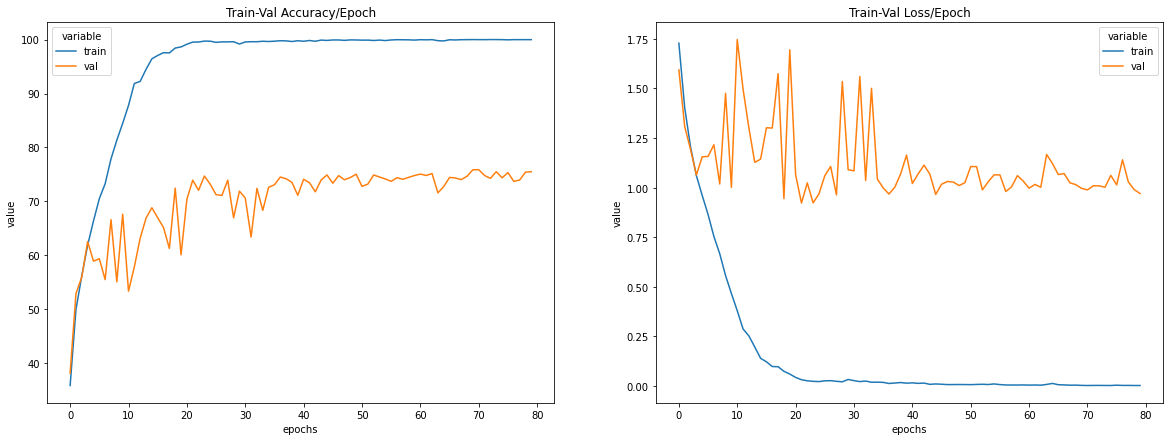

In [ ]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum()/len(correct_pred)
  acc = torch.round(acc*100)
  return acc

accuracy_stats = {'train':[], "val":[]}
loss_stats = {'train':[], "val":[]}
next(model.parameters()).is_cuda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
epochs = 80

print('Begin training...')
start_time = time.time()
print(start_time)
for e in tqdm(range(1, epochs+1)):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device),y_train_batch.to(device)
    optimizer.zero_grad()
    y_train_pred = model(X_train_batch)
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()

  model.eval()
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0

    for X_val_batch, y_val_batch in valid_loader:
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
      y_val_pred = model(X_val_batch)
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(valid_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(valid_loader))

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

print("--- %s seconds ---" % (time.time() - start_time))

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x="epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## **Testing and Confusion Matrix**

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       250
           1       0.83      0.84      0.84       250
           2       0.63      0.53      0.58       250
           3       0.57      0.54      0.55       250
           4       0.67      0.62      0.64       250
           5       0.62      0.65      0.63       250
           6       0.73      0.82      0.77       250
           7       0.71      0.73      0.72       250
           8       0.89      0.83      0.86       250
           9       0.82      0.86      0.84       250

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



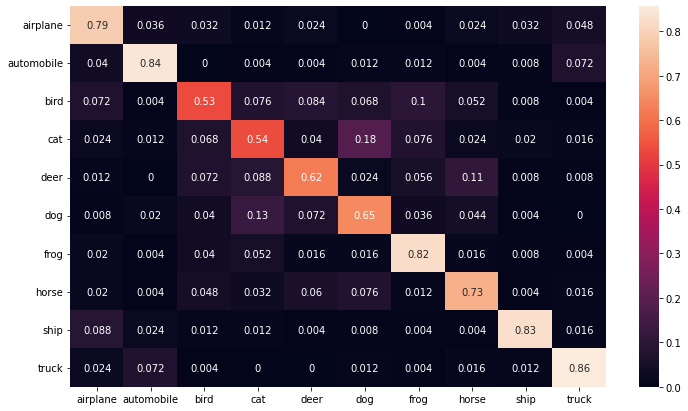

In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

print(classification_report(y_true, y_pred))

# **MiniGoogLeNet architecture with p=0.3**

In [ ]:
# minigooglenet architecture
class miniGoogLeNet(nn.Module):
    def __init__(self, num_class, size, depth):
        super().__init__()
        self.num_class = num_class
        self.size = size
        self.depth = depth
        self.conv = convMod(in_channels=depth, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.inception1 = inceptionMod(in_channels=96, k1x1=32, k3x3=32)
        self.inception2 = inceptionMod(in_channels=64, k1x1=32, k3x3=48)
        self.downsample1 = downsampleMod(in_channels=80, k=80)
        self.inception3 = inceptionMod(in_channels=160, k1x1=112, k3x3=48)
        self.inception4 = inceptionMod(in_channels=160, k1x1=96, k3x3=64)
        self.inception5 = inceptionMod(in_channels=160, k1x1=80, k3x3=80)
        self.inception6 = inceptionMod(in_channels=160, k1x1=48, k3x3=96)
        self.downsample2 = downsampleMod(in_channels=144, k=96)
        self.inception7 = inceptionMod(in_channels=240, k1x1=176, k3x3=160)
        self.inception8 = inceptionMod(in_channels=336, k1x1=176, k3x3=160)
        self.fc = nn.Linear(in_features=336, out_features=num_class)

    def forward(self, x): # input shape is 3x28x28
        x = self.conv(x)  # 96x28x28
        x = self.inception1(x) # 64x28x28
        x = self.inception2(x) # 80x28x28
        x = self.downsample1(x) # 160x13x13
        x = self.inception3(x) # 160x13x13
        x = self.inception4(x) # 160x13x13
        x = self.inception5(x) # 160x13x13
        x = self.inception6(x) # 144x13x13
        x = self.downsample2(x) # 240x6x6
        x = self.inception7(x) # 336x6x6
        x = self.inception8(x) # 336x6x6
        x = F.avg_pool2d(x, kernel_size=7) # 366x1x1
        x = F.dropout(x, p=0.3) # 366x1x1
        x = x.view(x.size(0), -1) # 366
        x = self.fc(x) # 10
        return x

class inceptionMod(nn.Module):
    def __init__(self, in_channels, k1x1, k3x3):
        super(inceptionMod, self).__init__()
        self.conv1 = convMod(in_channels, k1x1, kernel_size=1)
        self.conv3 = convMod(in_channels, k3x3, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        outputs = [conv1, conv3]
        return torch.cat(outputs, 1)

class downsampleMod(nn.Module):
    def __init__(self, in_channels, k):
        super(downsampleMod, self).__init__()
        self.conv = convMod(in_channels, k, kernel_size=3, stride=2)

    def forward(self, x):
        conv3 = self.conv(x)
        maxpool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [conv3, maxpool]
        return torch.cat(outputs, 1)

class convMod(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(convMod, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

model = miniGoogLeNet(len(classes), 32, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# architecture summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
       BatchNorm2d-2           [-1, 96, 32, 32]             192
           convMod-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           3,072
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           convMod-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          27,648
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           convMod-9           [-1, 32, 32, 32]               0
     inceptionMod-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           2,048
      BatchNorm2d-12           [-1, 32, 32, 32]              64
          convMod-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 48,

## **Training and initialization**

Begin training...
1636103197.4683943


  1%|▏         | 1/80 [00:23<31:17, 23.77s/it]

Epoch 001: | Train Loss: 1.73524 | Val Loss: 1.83384 | Train Acc: 35.184 | Val Acc: 36.032


  2%|▎         | 2/80 [00:47<30:48, 23.70s/it]

Epoch 002: | Train Loss: 1.41692 | Val Loss: 1.47248 | Train Acc: 48.370 | Val Acc: 47.120


  4%|▍         | 3/80 [01:11<30:22, 23.67s/it]

Epoch 003: | Train Loss: 1.24616 | Val Loss: 1.36291 | Train Acc: 55.202 | Val Acc: 51.064


  5%|▌         | 4/80 [01:34<29:59, 23.68s/it]

Epoch 004: | Train Loss: 1.11740 | Val Loss: 1.32043 | Train Acc: 59.564 | Val Acc: 53.416


  6%|▋         | 5/80 [01:58<29:32, 23.64s/it]

Epoch 005: | Train Loss: 1.00203 | Val Loss: 1.44156 | Train Acc: 64.442 | Val Acc: 53.432


  8%|▊         | 6/80 [02:21<29:07, 23.62s/it]

Epoch 006: | Train Loss: 0.90566 | Val Loss: 0.98364 | Train Acc: 67.910 | Val Acc: 65.576


  9%|▉         | 7/80 [02:45<28:45, 23.64s/it]

Epoch 007: | Train Loss: 0.80849 | Val Loss: 1.00610 | Train Acc: 71.536 | Val Acc: 64.368


 10%|█         | 8/80 [03:09<28:19, 23.61s/it]

Epoch 008: | Train Loss: 0.71882 | Val Loss: 1.25998 | Train Acc: 75.540 | Val Acc: 60.120


 11%|█▏        | 9/80 [03:32<27:56, 23.61s/it]

Epoch 009: | Train Loss: 0.63001 | Val Loss: 1.22068 | Train Acc: 78.458 | Val Acc: 62.568


 12%|█▎        | 10/80 [03:56<27:32, 23.61s/it]

Epoch 010: | Train Loss: 0.52582 | Val Loss: 1.12769 | Train Acc: 82.332 | Val Acc: 64.440


 14%|█▍        | 11/80 [04:20<27:10, 23.63s/it]

Epoch 011: | Train Loss: 0.45735 | Val Loss: 1.50097 | Train Acc: 85.170 | Val Acc: 56.144


 15%|█▌        | 12/80 [04:43<26:47, 23.65s/it]

Epoch 012: | Train Loss: 0.38910 | Val Loss: 2.34331 | Train Acc: 87.584 | Val Acc: 48.760


 16%|█▋        | 13/80 [05:07<26:23, 23.63s/it]

Epoch 013: | Train Loss: 0.30897 | Val Loss: 1.35434 | Train Acc: 89.924 | Val Acc: 62.048


 18%|█▊        | 14/80 [05:30<25:59, 23.62s/it]

Epoch 014: | Train Loss: 0.24867 | Val Loss: 1.40669 | Train Acc: 92.454 | Val Acc: 63.536


 19%|█▉        | 15/80 [05:54<25:35, 23.62s/it]

Epoch 015: | Train Loss: 0.21691 | Val Loss: 1.32469 | Train Acc: 93.364 | Val Acc: 63.624


 20%|██        | 16/80 [06:18<25:12, 23.63s/it]

Epoch 016: | Train Loss: 0.16051 | Val Loss: 1.20614 | Train Acc: 95.480 | Val Acc: 66.920


 21%|██▏       | 17/80 [06:41<24:49, 23.64s/it]

Epoch 017: | Train Loss: 0.14453 | Val Loss: 1.04456 | Train Acc: 96.220 | Val Acc: 71.112


 22%|██▎       | 18/80 [07:05<24:24, 23.63s/it]

Epoch 018: | Train Loss: 0.12353 | Val Loss: 1.20969 | Train Acc: 96.624 | Val Acc: 66.584


 24%|██▍       | 19/80 [07:29<24:02, 23.65s/it]

Epoch 019: | Train Loss: 0.08865 | Val Loss: 1.16609 | Train Acc: 97.864 | Val Acc: 68.528


 25%|██▌       | 20/80 [07:52<23:38, 23.64s/it]

Epoch 020: | Train Loss: 0.08161 | Val Loss: 1.00470 | Train Acc: 97.914 | Val Acc: 72.032


 26%|██▋       | 21/80 [08:16<23:14, 23.64s/it]

Epoch 021: | Train Loss: 0.07564 | Val Loss: 1.03856 | Train Acc: 98.166 | Val Acc: 72.264


 28%|██▊       | 22/80 [08:39<22:50, 23.63s/it]

Epoch 022: | Train Loss: 0.05604 | Val Loss: 1.01028 | Train Acc: 98.872 | Val Acc: 71.072


 29%|██▉       | 23/80 [09:03<22:26, 23.62s/it]

Epoch 023: | Train Loss: 0.05427 | Val Loss: 1.11264 | Train Acc: 98.798 | Val Acc: 69.560


 30%|███       | 24/80 [09:27<22:02, 23.61s/it]

Epoch 024: | Train Loss: 0.04954 | Val Loss: 1.10560 | Train Acc: 98.906 | Val Acc: 70.320


 31%|███▏      | 25/80 [09:50<21:38, 23.62s/it]

Epoch 025: | Train Loss: 0.05924 | Val Loss: 1.26636 | Train Acc: 98.428 | Val Acc: 69.200


 32%|███▎      | 26/80 [10:14<21:16, 23.64s/it]

Epoch 026: | Train Loss: 0.04185 | Val Loss: 1.07070 | Train Acc: 99.098 | Val Acc: 72.584


 34%|███▍      | 27/80 [10:38<20:52, 23.63s/it]

Epoch 027: | Train Loss: 0.03112 | Val Loss: 1.10904 | Train Acc: 99.316 | Val Acc: 70.792


 35%|███▌      | 28/80 [11:01<20:28, 23.62s/it]

Epoch 028: | Train Loss: 0.03019 | Val Loss: 1.21106 | Train Acc: 99.346 | Val Acc: 70.616


 36%|███▋      | 29/80 [11:25<20:04, 23.62s/it]

Epoch 029: | Train Loss: 0.02023 | Val Loss: 0.96951 | Train Acc: 99.604 | Val Acc: 73.368


 38%|███▊      | 30/80 [11:48<19:41, 23.63s/it]

Epoch 030: | Train Loss: 0.01807 | Val Loss: 1.02677 | Train Acc: 99.676 | Val Acc: 72.256


 39%|███▉      | 31/80 [12:12<19:17, 23.62s/it]

Epoch 031: | Train Loss: 0.01677 | Val Loss: 1.02903 | Train Acc: 99.736 | Val Acc: 73.344


 40%|████      | 32/80 [12:36<18:54, 23.63s/it]

Epoch 032: | Train Loss: 0.01644 | Val Loss: 0.99589 | Train Acc: 99.736 | Val Acc: 73.800


 41%|████▏     | 33/80 [12:59<18:31, 23.66s/it]

Epoch 033: | Train Loss: 0.01488 | Val Loss: 1.14518 | Train Acc: 99.782 | Val Acc: 72.304


 42%|████▎     | 34/80 [13:23<18:07, 23.64s/it]

Epoch 034: | Train Loss: 0.01579 | Val Loss: 1.07106 | Train Acc: 99.688 | Val Acc: 72.024


 44%|████▍     | 35/80 [13:47<17:44, 23.65s/it]

Epoch 035: | Train Loss: 0.02264 | Val Loss: 1.06152 | Train Acc: 99.578 | Val Acc: 73.016


 45%|████▌     | 36/80 [14:10<17:19, 23.63s/it]

Epoch 036: | Train Loss: 0.01665 | Val Loss: 1.13997 | Train Acc: 99.712 | Val Acc: 72.424


 46%|████▋     | 37/80 [14:34<16:55, 23.63s/it]

Epoch 037: | Train Loss: 0.01199 | Val Loss: 1.00838 | Train Acc: 99.856 | Val Acc: 74.768


 48%|████▊     | 38/80 [14:58<16:32, 23.63s/it]

Epoch 038: | Train Loss: 0.01148 | Val Loss: 1.15756 | Train Acc: 99.868 | Val Acc: 72.440


 49%|████▉     | 39/80 [15:21<16:08, 23.63s/it]

Epoch 039: | Train Loss: 0.00924 | Val Loss: 1.01052 | Train Acc: 99.940 | Val Acc: 74.088


 50%|█████     | 40/80 [15:45<15:45, 23.64s/it]

Epoch 040: | Train Loss: 0.00846 | Val Loss: 1.19286 | Train Acc: 99.880 | Val Acc: 72.240


 51%|█████▏    | 41/80 [16:08<15:21, 23.63s/it]

Epoch 041: | Train Loss: 0.01256 | Val Loss: 1.06838 | Train Acc: 99.748 | Val Acc: 73.536


 52%|█████▎    | 42/80 [16:32<14:58, 23.64s/it]

Epoch 042: | Train Loss: 0.01112 | Val Loss: 1.01925 | Train Acc: 99.868 | Val Acc: 73.776


 54%|█████▍    | 43/80 [16:56<14:35, 23.65s/it]

Epoch 043: | Train Loss: 0.01473 | Val Loss: 1.02288 | Train Acc: 99.724 | Val Acc: 73.672


 55%|█████▌    | 44/80 [17:19<14:10, 23.63s/it]

Epoch 044: | Train Loss: 0.01369 | Val Loss: 1.02482 | Train Acc: 99.736 | Val Acc: 72.888


 56%|█████▋    | 45/80 [17:43<13:47, 23.64s/it]

Epoch 045: | Train Loss: 0.00962 | Val Loss: 1.09839 | Train Acc: 99.880 | Val Acc: 72.392


 57%|█████▊    | 46/80 [18:07<13:22, 23.61s/it]

Epoch 046: | Train Loss: 0.01380 | Val Loss: 1.06864 | Train Acc: 99.736 | Val Acc: 73.640


 59%|█████▉    | 47/80 [18:30<12:58, 23.58s/it]

Epoch 047: | Train Loss: 0.01145 | Val Loss: 1.06523 | Train Acc: 99.772 | Val Acc: 72.904


 60%|██████    | 48/80 [18:54<12:34, 23.59s/it]

Epoch 048: | Train Loss: 0.01933 | Val Loss: 1.29864 | Train Acc: 99.628 | Val Acc: 69.144


 61%|██████▏   | 49/80 [19:17<12:11, 23.60s/it]

Epoch 049: | Train Loss: 0.01805 | Val Loss: 1.04971 | Train Acc: 99.616 | Val Acc: 73.440


 62%|██████▎   | 50/80 [19:41<11:48, 23.62s/it]

Epoch 050: | Train Loss: 0.01024 | Val Loss: 1.30334 | Train Acc: 99.844 | Val Acc: 71.656


 64%|██████▍   | 51/80 [20:05<11:24, 23.62s/it]

Epoch 051: | Train Loss: 0.00954 | Val Loss: 1.04891 | Train Acc: 99.832 | Val Acc: 73.336


 65%|██████▌   | 52/80 [20:28<11:01, 23.62s/it]

Epoch 052: | Train Loss: 0.00729 | Val Loss: 1.04153 | Train Acc: 99.928 | Val Acc: 74.768


 66%|██████▋   | 53/80 [20:52<10:37, 23.62s/it]

Epoch 053: | Train Loss: 0.00900 | Val Loss: 1.06272 | Train Acc: 99.832 | Val Acc: 73.840


 68%|██████▊   | 54/80 [21:16<10:14, 23.63s/it]

Epoch 054: | Train Loss: 0.00803 | Val Loss: 1.06362 | Train Acc: 99.856 | Val Acc: 72.952


 69%|██████▉   | 55/80 [21:39<09:50, 23.63s/it]

Epoch 055: | Train Loss: 0.00748 | Val Loss: 1.09117 | Train Acc: 99.880 | Val Acc: 72.768


 70%|███████   | 56/80 [22:03<09:27, 23.63s/it]

Epoch 056: | Train Loss: 0.00691 | Val Loss: 1.07815 | Train Acc: 99.904 | Val Acc: 72.824


 71%|███████▏  | 57/80 [22:26<09:03, 23.61s/it]

Epoch 057: | Train Loss: 0.00912 | Val Loss: 1.08567 | Train Acc: 99.844 | Val Acc: 73.048


 72%|███████▎  | 58/80 [22:50<08:39, 23.60s/it]

Epoch 058: | Train Loss: 0.00568 | Val Loss: 1.09778 | Train Acc: 99.904 | Val Acc: 73.200


 74%|███████▍  | 59/80 [23:13<08:15, 23.59s/it]

Epoch 059: | Train Loss: 0.00489 | Val Loss: 0.99632 | Train Acc: 99.940 | Val Acc: 74.880


 75%|███████▌  | 60/80 [23:37<07:51, 23.60s/it]

Epoch 060: | Train Loss: 0.00497 | Val Loss: 1.07931 | Train Acc: 99.940 | Val Acc: 74.040


 76%|███████▋  | 61/80 [24:01<07:27, 23.58s/it]

Epoch 061: | Train Loss: 0.00839 | Val Loss: 1.12666 | Train Acc: 99.820 | Val Acc: 72.752


 78%|███████▊  | 62/80 [24:24<07:04, 23.56s/it]

Epoch 062: | Train Loss: 0.00900 | Val Loss: 1.10805 | Train Acc: 99.820 | Val Acc: 72.488


 79%|███████▉  | 63/80 [24:48<06:40, 23.55s/it]

Epoch 063: | Train Loss: 0.00663 | Val Loss: 1.10929 | Train Acc: 99.916 | Val Acc: 72.528


 80%|████████  | 64/80 [25:11<06:16, 23.52s/it]

Epoch 064: | Train Loss: 0.00598 | Val Loss: 1.05582 | Train Acc: 99.880 | Val Acc: 73.952


 81%|████████▏ | 65/80 [25:35<05:52, 23.50s/it]

Epoch 065: | Train Loss: 0.00649 | Val Loss: 1.07767 | Train Acc: 99.904 | Val Acc: 73.040


 82%|████████▎ | 66/80 [25:58<05:29, 23.51s/it]

Epoch 066: | Train Loss: 0.00490 | Val Loss: 1.04599 | Train Acc: 99.928 | Val Acc: 74.472


 84%|████████▍ | 67/80 [26:22<05:05, 23.54s/it]

Epoch 067: | Train Loss: 0.00511 | Val Loss: 1.13105 | Train Acc: 99.928 | Val Acc: 73.496


 85%|████████▌ | 68/80 [26:45<04:42, 23.58s/it]

Epoch 068: | Train Loss: 0.00465 | Val Loss: 1.08034 | Train Acc: 99.952 | Val Acc: 73.256


 86%|████████▋ | 69/80 [27:09<04:19, 23.61s/it]

Epoch 069: | Train Loss: 0.00566 | Val Loss: 1.07124 | Train Acc: 99.904 | Val Acc: 74.104


 88%|████████▊ | 70/80 [27:33<03:56, 23.62s/it]

Epoch 070: | Train Loss: 0.00505 | Val Loss: 1.09838 | Train Acc: 99.928 | Val Acc: 73.600


 89%|████████▉ | 71/80 [27:56<03:32, 23.63s/it]

Epoch 071: | Train Loss: 0.00425 | Val Loss: 1.23207 | Train Acc: 99.952 | Val Acc: 72.200


 90%|█████████ | 72/80 [28:20<03:09, 23.64s/it]

Epoch 072: | Train Loss: 0.00328 | Val Loss: 1.03816 | Train Acc: 99.988 | Val Acc: 75.088


 91%|█████████▏| 73/80 [28:44<02:45, 23.64s/it]

Epoch 073: | Train Loss: 0.00362 | Val Loss: 1.07346 | Train Acc: 99.952 | Val Acc: 74.480


 92%|█████████▎| 74/80 [29:07<02:21, 23.64s/it]

Epoch 074: | Train Loss: 0.00687 | Val Loss: 1.09533 | Train Acc: 99.844 | Val Acc: 73.288


 94%|█████████▍| 75/80 [29:31<01:58, 23.66s/it]

Epoch 075: | Train Loss: 0.00293 | Val Loss: 1.04479 | Train Acc: 99.988 | Val Acc: 74.696


 95%|█████████▌| 76/80 [29:55<01:34, 23.64s/it]

Epoch 076: | Train Loss: 0.00288 | Val Loss: 1.09218 | Train Acc: 99.940 | Val Acc: 73.992


 96%|█████████▋| 77/80 [30:18<01:10, 23.63s/it]

Epoch 077: | Train Loss: 0.00441 | Val Loss: 1.08776 | Train Acc: 99.952 | Val Acc: 74.752


 98%|█████████▊| 78/80 [30:42<00:47, 23.61s/it]

Epoch 078: | Train Loss: 0.00375 | Val Loss: 1.24071 | Train Acc: 99.988 | Val Acc: 71.800


 99%|█████████▉| 79/80 [31:05<00:23, 23.62s/it]

Epoch 079: | Train Loss: 0.00240 | Val Loss: 1.08717 | Train Acc: 100.000 | Val Acc: 75.072


100%|██████████| 80/80 [31:29<00:00, 23.62s/it]

Epoch 080: | Train Loss: 0.00192 | Val Loss: 1.08715 | Train Acc: 100.000 | Val Acc: 75.168
--- 1889.545986175537 seconds ---


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

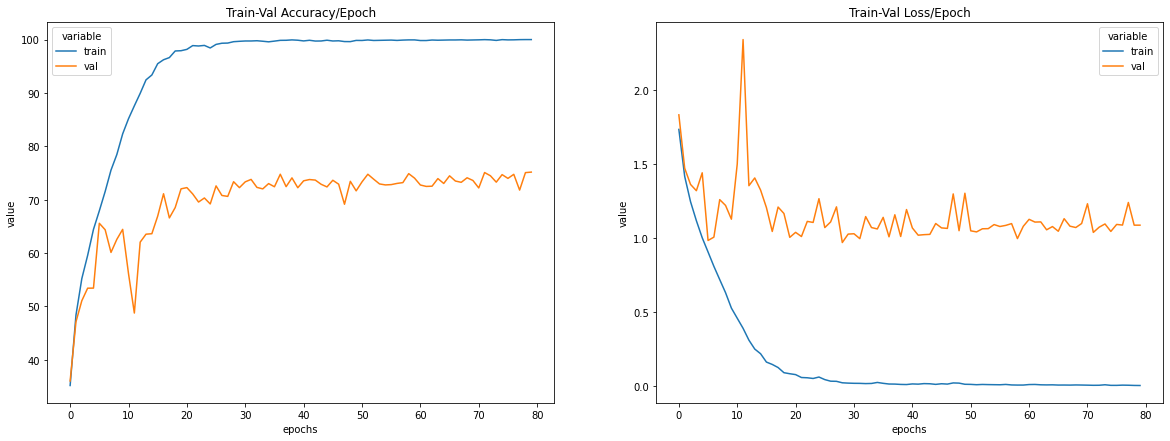

In [ ]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum()/len(correct_pred)
  acc = torch.round(acc*100)
  return acc

accuracy_stats = {'train':[], "val":[]}
loss_stats = {'train':[], "val":[]}
next(model.parameters()).is_cuda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
epochs = 80

print('Begin training...')
start_time = time.time()
print(start_time)
for e in tqdm(range(1, epochs+1)):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device),y_train_batch.to(device)
    optimizer.zero_grad()
    y_train_pred = model(X_train_batch)
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()

  model.eval()
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0

    for X_val_batch, y_val_batch in valid_loader:
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
      y_val_pred = model(X_val_batch)
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(valid_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(valid_loader))

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

print("--- %s seconds ---" % (time.time() - start_time))

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x="epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## **Testing and Confusion Matrix**

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       250
           1       0.85      0.82      0.83       250
           2       0.64      0.52      0.57       250
           3       0.56      0.51      0.54       250
           4       0.68      0.64      0.66       250
           5       0.66      0.65      0.66       250
           6       0.66      0.88      0.75       250
           7       0.76      0.70      0.73       250
           8       0.87      0.86      0.87       250
           9       0.82      0.87      0.85       250

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



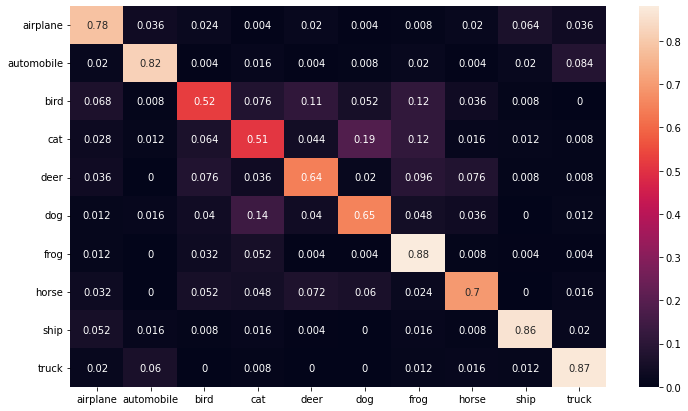

In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

print(classification_report(y_true, y_pred))

# **MiniGoogLeNet architecture with p=0.5**

In [ ]:
# minigooglenet architecture
class miniGoogLeNet(nn.Module):
    def __init__(self, num_class, size, depth):
        super().__init__()
        self.num_class = num_class
        self.size = size
        self.depth = depth
        self.conv = convMod(in_channels=depth, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.inception1 = inceptionMod(in_channels=96, k1x1=32, k3x3=32)
        self.inception2 = inceptionMod(in_channels=64, k1x1=32, k3x3=48)
        self.downsample1 = downsampleMod(in_channels=80, k=80)
        self.inception3 = inceptionMod(in_channels=160, k1x1=112, k3x3=48)
        self.inception4 = inceptionMod(in_channels=160, k1x1=96, k3x3=64)
        self.inception5 = inceptionMod(in_channels=160, k1x1=80, k3x3=80)
        self.inception6 = inceptionMod(in_channels=160, k1x1=48, k3x3=96)
        self.downsample2 = downsampleMod(in_channels=144, k=96)
        self.inception7 = inceptionMod(in_channels=240, k1x1=176, k3x3=160)
        self.inception8 = inceptionMod(in_channels=336, k1x1=176, k3x3=160)
        self.fc = nn.Linear(in_features=336, out_features=num_class)

    def forward(self, x): # input shape is 3x28x28
        x = self.conv(x)  # 96x28x28
        x = self.inception1(x) # 64x28x28
        x = self.inception2(x) # 80x28x28
        x = self.downsample1(x) # 160x13x13
        x = self.inception3(x) # 160x13x13
        x = self.inception4(x) # 160x13x13
        x = self.inception5(x) # 160x13x13
        x = self.inception6(x) # 144x13x13
        x = self.downsample2(x) # 240x6x6
        x = self.inception7(x) # 336x6x6
        x = self.inception8(x) # 336x6x6
        x = F.avg_pool2d(x, kernel_size=7) # 366x1x1
        x = F.dropout(x, p=0.5) # 366x1x1
        x = x.view(x.size(0), -1) # 366
        x = self.fc(x) # 10
        return x

class inceptionMod(nn.Module):
    def __init__(self, in_channels, k1x1, k3x3):
        super(inceptionMod, self).__init__()
        self.conv1 = convMod(in_channels, k1x1, kernel_size=1)
        self.conv3 = convMod(in_channels, k3x3, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        outputs = [conv1, conv3]
        return torch.cat(outputs, 1)

class downsampleMod(nn.Module):
    def __init__(self, in_channels, k):
        super(downsampleMod, self).__init__()
        self.conv = convMod(in_channels, k, kernel_size=3, stride=2)

    def forward(self, x):
        conv3 = self.conv(x)
        maxpool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [conv3, maxpool]
        return torch.cat(outputs, 1)

class convMod(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(convMod, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

model = miniGoogLeNet(len(classes), 32, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# architecture summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
       BatchNorm2d-2           [-1, 96, 32, 32]             192
           convMod-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           3,072
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           convMod-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          27,648
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           convMod-9           [-1, 32, 32, 32]               0
     inceptionMod-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           2,048
      BatchNorm2d-12           [-1, 32, 32, 32]              64
          convMod-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 48,

## **Training and initialization**

Begin training...
1636105093.6198058


  1%|▏         | 1/80 [00:23<31:14, 23.73s/it]

Epoch 001: | Train Loss: 1.75621 | Val Loss: 1.58512 | Train Acc: 34.092 | Val Acc: 40.448


  2%|▎         | 2/80 [00:47<30:47, 23.69s/it]

Epoch 002: | Train Loss: 1.43171 | Val Loss: 1.47842 | Train Acc: 48.222 | Val Acc: 48.360


  4%|▍         | 3/80 [01:11<30:23, 23.69s/it]

Epoch 003: | Train Loss: 1.26936 | Val Loss: 1.46071 | Train Acc: 54.134 | Val Acc: 49.080


  5%|▌         | 4/80 [01:34<29:59, 23.67s/it]

Epoch 004: | Train Loss: 1.13424 | Val Loss: 1.06113 | Train Acc: 59.124 | Val Acc: 62.056


  6%|▋         | 5/80 [01:58<29:35, 23.68s/it]

Epoch 005: | Train Loss: 1.02285 | Val Loss: 1.17465 | Train Acc: 63.808 | Val Acc: 57.384


  8%|▊         | 6/80 [02:22<29:11, 23.67s/it]

Epoch 006: | Train Loss: 0.94039 | Val Loss: 1.02331 | Train Acc: 66.870 | Val Acc: 63.864


  9%|▉         | 7/80 [02:45<28:50, 23.71s/it]

Epoch 007: | Train Loss: 0.85111 | Val Loss: 0.98327 | Train Acc: 69.574 | Val Acc: 65.984


 10%|█         | 8/80 [03:09<28:23, 23.66s/it]

Epoch 008: | Train Loss: 0.77539 | Val Loss: 1.11573 | Train Acc: 73.054 | Val Acc: 62.608


 11%|█▏        | 9/80 [03:33<27:59, 23.65s/it]

Epoch 009: | Train Loss: 0.67094 | Val Loss: 1.43886 | Train Acc: 76.544 | Val Acc: 56.272


 12%|█▎        | 10/80 [03:56<27:35, 23.66s/it]

Epoch 010: | Train Loss: 0.59652 | Val Loss: 1.12929 | Train Acc: 79.170 | Val Acc: 65.400


 14%|█▍        | 11/80 [04:20<27:11, 23.64s/it]

Epoch 011: | Train Loss: 0.49748 | Val Loss: 1.29498 | Train Acc: 83.426 | Val Acc: 59.704


 15%|█▌        | 12/80 [04:43<26:47, 23.64s/it]

Epoch 012: | Train Loss: 0.43964 | Val Loss: 1.48480 | Train Acc: 85.164 | Val Acc: 60.424


 16%|█▋        | 13/80 [05:07<26:23, 23.63s/it]

Epoch 013: | Train Loss: 0.36470 | Val Loss: 1.22521 | Train Acc: 88.258 | Val Acc: 62.512


 18%|█▊        | 14/80 [05:31<26:00, 23.64s/it]

Epoch 014: | Train Loss: 0.29414 | Val Loss: 1.06259 | Train Acc: 90.668 | Val Acc: 67.424


 19%|█▉        | 15/80 [05:54<25:34, 23.61s/it]

Epoch 015: | Train Loss: 0.25429 | Val Loss: 1.09498 | Train Acc: 92.270 | Val Acc: 67.040


 20%|██        | 16/80 [06:18<25:11, 23.62s/it]

Epoch 016: | Train Loss: 0.22118 | Val Loss: 1.27961 | Train Acc: 93.296 | Val Acc: 62.752


 21%|██▏       | 17/80 [06:42<24:48, 23.62s/it]

Epoch 017: | Train Loss: 0.20607 | Val Loss: 0.96682 | Train Acc: 93.632 | Val Acc: 70.120


 22%|██▎       | 18/80 [07:05<24:24, 23.62s/it]

Epoch 018: | Train Loss: 0.15124 | Val Loss: 1.90747 | Train Acc: 95.558 | Val Acc: 57.032


 24%|██▍       | 19/80 [07:29<24:01, 23.63s/it]

Epoch 019: | Train Loss: 0.13134 | Val Loss: 2.36967 | Train Acc: 96.244 | Val Acc: 51.736


 25%|██▌       | 20/80 [07:52<23:38, 23.64s/it]

Epoch 020: | Train Loss: 0.11175 | Val Loss: 1.17040 | Train Acc: 96.914 | Val Acc: 68.200


 26%|██▋       | 21/80 [08:16<23:16, 23.67s/it]

Epoch 021: | Train Loss: 0.10490 | Val Loss: 1.23122 | Train Acc: 97.216 | Val Acc: 67.160


 28%|██▊       | 22/80 [08:40<22:52, 23.66s/it]

Epoch 022: | Train Loss: 0.09502 | Val Loss: 1.30046 | Train Acc: 97.350 | Val Acc: 67.432


 29%|██▉       | 23/80 [09:04<22:28, 23.66s/it]

Epoch 023: | Train Loss: 0.07088 | Val Loss: 1.56076 | Train Acc: 98.422 | Val Acc: 60.824


 30%|███       | 24/80 [09:27<22:04, 23.65s/it]

Epoch 024: | Train Loss: 0.05386 | Val Loss: 1.14733 | Train Acc: 98.676 | Val Acc: 70.520


 31%|███▏      | 25/80 [09:51<21:40, 23.65s/it]

Epoch 025: | Train Loss: 0.06195 | Val Loss: 1.43939 | Train Acc: 98.460 | Val Acc: 66.608


 32%|███▎      | 26/80 [10:14<21:16, 23.64s/it]

Epoch 026: | Train Loss: 0.07153 | Val Loss: 1.15603 | Train Acc: 97.914 | Val Acc: 70.120


 34%|███▍      | 27/80 [10:38<20:53, 23.65s/it]

Epoch 027: | Train Loss: 0.06732 | Val Loss: 1.56918 | Train Acc: 98.040 | Val Acc: 63.056


 35%|███▌      | 28/80 [11:02<20:31, 23.68s/it]

Epoch 028: | Train Loss: 0.06244 | Val Loss: 2.03015 | Train Acc: 98.294 | Val Acc: 60.264


 36%|███▋      | 29/80 [11:26<20:07, 23.68s/it]

Epoch 029: | Train Loss: 0.04284 | Val Loss: 1.14840 | Train Acc: 99.000 | Val Acc: 70.184


 38%|███▊      | 30/80 [11:49<19:43, 23.66s/it]

Epoch 030: | Train Loss: 0.04705 | Val Loss: 1.55322 | Train Acc: 98.748 | Val Acc: 64.752


 39%|███▉      | 31/80 [12:13<19:19, 23.66s/it]

Epoch 031: | Train Loss: 0.05134 | Val Loss: 2.04693 | Train Acc: 98.700 | Val Acc: 60.576


 40%|████      | 32/80 [12:36<18:55, 23.65s/it]

Epoch 032: | Train Loss: 0.04678 | Val Loss: 1.84399 | Train Acc: 98.798 | Val Acc: 61.544


 41%|████▏     | 33/80 [13:00<18:31, 23.65s/it]

Epoch 033: | Train Loss: 0.03882 | Val Loss: 1.19740 | Train Acc: 98.974 | Val Acc: 69.600


 42%|████▎     | 34/80 [13:24<18:08, 23.66s/it]

Epoch 034: | Train Loss: 0.04061 | Val Loss: 1.44575 | Train Acc: 98.932 | Val Acc: 67.520


 44%|████▍     | 35/80 [13:47<17:45, 23.68s/it]

Epoch 035: | Train Loss: 0.04039 | Val Loss: 1.12620 | Train Acc: 99.014 | Val Acc: 70.568


 45%|████▌     | 36/80 [14:11<17:21, 23.67s/it]

Epoch 036: | Train Loss: 0.04227 | Val Loss: 1.51430 | Train Acc: 98.916 | Val Acc: 65.536


 46%|████▋     | 37/80 [14:35<16:57, 23.67s/it]

Epoch 037: | Train Loss: 0.02605 | Val Loss: 1.76417 | Train Acc: 99.532 | Val Acc: 65.816


 48%|████▊     | 38/80 [14:58<16:34, 23.67s/it]

Epoch 038: | Train Loss: 0.03436 | Val Loss: 1.16616 | Train Acc: 99.144 | Val Acc: 70.048


 49%|████▉     | 39/80 [15:22<16:10, 23.66s/it]

Epoch 039: | Train Loss: 0.02515 | Val Loss: 1.33885 | Train Acc: 99.436 | Val Acc: 68.496


 50%|█████     | 40/80 [15:46<15:46, 23.65s/it]

Epoch 040: | Train Loss: 0.02962 | Val Loss: 1.46548 | Train Acc: 99.206 | Val Acc: 67.312


 51%|█████▏    | 41/80 [16:09<15:22, 23.66s/it]

Epoch 041: | Train Loss: 0.02240 | Val Loss: 1.21140 | Train Acc: 99.460 | Val Acc: 70.312


 52%|█████▎    | 42/80 [16:33<14:59, 23.68s/it]

Epoch 042: | Train Loss: 0.01749 | Val Loss: 1.20963 | Train Acc: 99.628 | Val Acc: 70.120


 54%|█████▍    | 43/80 [16:57<14:36, 23.68s/it]

Epoch 043: | Train Loss: 0.02275 | Val Loss: 1.17267 | Train Acc: 99.412 | Val Acc: 71.400


 55%|█████▌    | 44/80 [17:20<14:12, 23.68s/it]

Epoch 044: | Train Loss: 0.02704 | Val Loss: 1.15619 | Train Acc: 99.340 | Val Acc: 71.256


 56%|█████▋    | 45/80 [17:44<13:48, 23.66s/it]

Epoch 045: | Train Loss: 0.02072 | Val Loss: 1.22270 | Train Acc: 99.566 | Val Acc: 70.792


 57%|█████▊    | 46/80 [18:08<13:24, 23.66s/it]

Epoch 046: | Train Loss: 0.01378 | Val Loss: 1.09961 | Train Acc: 99.772 | Val Acc: 72.312


 59%|█████▉    | 47/80 [18:31<13:00, 23.66s/it]

Epoch 047: | Train Loss: 0.01060 | Val Loss: 1.14172 | Train Acc: 99.808 | Val Acc: 71.320


 60%|██████    | 48/80 [18:55<12:37, 23.66s/it]

Epoch 048: | Train Loss: 0.01412 | Val Loss: 1.15476 | Train Acc: 99.700 | Val Acc: 72.232


 61%|██████▏   | 49/80 [19:19<12:14, 23.69s/it]

Epoch 049: | Train Loss: 0.01265 | Val Loss: 1.12753 | Train Acc: 99.748 | Val Acc: 72.672


 62%|██████▎   | 50/80 [19:42<11:50, 23.67s/it]

Epoch 050: | Train Loss: 0.01294 | Val Loss: 1.25299 | Train Acc: 99.796 | Val Acc: 71.464


 64%|██████▍   | 51/80 [20:06<11:26, 23.68s/it]

Epoch 051: | Train Loss: 0.01256 | Val Loss: 1.10628 | Train Acc: 99.746 | Val Acc: 73.080


 65%|██████▌   | 52/80 [20:30<11:02, 23.67s/it]

Epoch 052: | Train Loss: 0.01176 | Val Loss: 1.21258 | Train Acc: 99.760 | Val Acc: 71.784


 66%|██████▋   | 53/80 [20:53<10:38, 23.66s/it]

Epoch 053: | Train Loss: 0.01005 | Val Loss: 1.15676 | Train Acc: 99.880 | Val Acc: 72.224


 68%|██████▊   | 54/80 [21:17<10:15, 23.66s/it]

Epoch 054: | Train Loss: 0.01279 | Val Loss: 1.20819 | Train Acc: 99.710 | Val Acc: 71.376


 69%|██████▉   | 55/80 [21:41<09:51, 23.67s/it]

Epoch 055: | Train Loss: 0.00924 | Val Loss: 1.23277 | Train Acc: 99.844 | Val Acc: 71.960


 70%|███████   | 56/80 [22:05<09:28, 23.68s/it]

Epoch 056: | Train Loss: 0.00842 | Val Loss: 1.14740 | Train Acc: 99.868 | Val Acc: 73.200


 71%|███████▏  | 57/80 [22:28<09:04, 23.67s/it]

Epoch 057: | Train Loss: 0.01216 | Val Loss: 1.20275 | Train Acc: 99.712 | Val Acc: 71.048


 72%|███████▎  | 58/80 [22:52<08:40, 23.66s/it]

Epoch 058: | Train Loss: 0.01291 | Val Loss: 1.57680 | Train Acc: 99.734 | Val Acc: 67.120


 74%|███████▍  | 59/80 [23:16<08:17, 23.68s/it]

Epoch 059: | Train Loss: 0.00780 | Val Loss: 1.16072 | Train Acc: 99.880 | Val Acc: 72.792


 75%|███████▌  | 60/80 [23:39<07:53, 23.67s/it]

Epoch 060: | Train Loss: 0.01562 | Val Loss: 1.26308 | Train Acc: 99.604 | Val Acc: 69.648


 76%|███████▋  | 61/80 [24:03<07:29, 23.66s/it]

Epoch 061: | Train Loss: 0.01284 | Val Loss: 1.15682 | Train Acc: 99.700 | Val Acc: 73.024


 78%|███████▊  | 62/80 [24:26<07:05, 23.66s/it]

Epoch 062: | Train Loss: 0.01004 | Val Loss: 1.18717 | Train Acc: 99.820 | Val Acc: 72.016


 79%|███████▉  | 63/80 [24:50<06:42, 23.68s/it]

Epoch 063: | Train Loss: 0.00781 | Val Loss: 1.17381 | Train Acc: 99.880 | Val Acc: 71.832


 80%|████████  | 64/80 [25:14<06:18, 23.67s/it]

Epoch 064: | Train Loss: 0.00839 | Val Loss: 1.14639 | Train Acc: 99.820 | Val Acc: 72.616


 81%|████████▏ | 65/80 [25:37<05:54, 23.66s/it]

Epoch 065: | Train Loss: 0.00993 | Val Loss: 1.22909 | Train Acc: 99.796 | Val Acc: 71.632


 82%|████████▎ | 66/80 [26:01<05:31, 23.67s/it]

Epoch 066: | Train Loss: 0.00965 | Val Loss: 1.68302 | Train Acc: 99.820 | Val Acc: 65.680


 84%|████████▍ | 67/80 [26:25<05:07, 23.65s/it]

Epoch 067: | Train Loss: 0.01051 | Val Loss: 1.22333 | Train Acc: 99.770 | Val Acc: 71.440


 85%|████████▌ | 68/80 [26:48<04:43, 23.65s/it]

Epoch 068: | Train Loss: 0.00690 | Val Loss: 1.21645 | Train Acc: 99.880 | Val Acc: 72.336


 86%|████████▋ | 69/80 [27:12<04:20, 23.64s/it]

Epoch 069: | Train Loss: 0.00997 | Val Loss: 1.21053 | Train Acc: 99.844 | Val Acc: 71.736


 88%|████████▊ | 70/80 [27:36<03:56, 23.66s/it]

Epoch 070: | Train Loss: 0.00874 | Val Loss: 1.16906 | Train Acc: 99.808 | Val Acc: 72.184


 89%|████████▉ | 71/80 [27:59<03:32, 23.67s/it]

Epoch 071: | Train Loss: 0.00516 | Val Loss: 1.13244 | Train Acc: 99.952 | Val Acc: 72.800


 90%|█████████ | 72/80 [28:23<03:09, 23.67s/it]

Epoch 072: | Train Loss: 0.00507 | Val Loss: 1.19859 | Train Acc: 99.916 | Val Acc: 72.088


 91%|█████████▏| 73/80 [28:47<02:45, 23.67s/it]

Epoch 073: | Train Loss: 0.00675 | Val Loss: 1.21696 | Train Acc: 99.892 | Val Acc: 71.216


 92%|█████████▎| 74/80 [29:10<02:21, 23.66s/it]

Epoch 074: | Train Loss: 0.00557 | Val Loss: 1.21252 | Train Acc: 99.952 | Val Acc: 71.000


 94%|█████████▍| 75/80 [29:34<01:58, 23.66s/it]

Epoch 075: | Train Loss: 0.00528 | Val Loss: 1.13267 | Train Acc: 99.904 | Val Acc: 72.808


 95%|█████████▌| 76/80 [29:58<01:34, 23.65s/it]

Epoch 076: | Train Loss: 0.00574 | Val Loss: 1.25793 | Train Acc: 99.940 | Val Acc: 71.000


 96%|█████████▋| 77/80 [30:21<01:11, 23.68s/it]

Epoch 077: | Train Loss: 0.00478 | Val Loss: 1.33248 | Train Acc: 99.940 | Val Acc: 70.824


 98%|█████████▊| 78/80 [30:45<00:47, 23.67s/it]

Epoch 078: | Train Loss: 0.00266 | Val Loss: 1.13602 | Train Acc: 99.988 | Val Acc: 73.112


 99%|█████████▉| 79/80 [31:09<00:23, 23.67s/it]

Epoch 079: | Train Loss: 0.00327 | Val Loss: 1.17728 | Train Acc: 99.940 | Val Acc: 72.632


100%|██████████| 80/80 [31:32<00:00, 23.66s/it]

Epoch 080: | Train Loss: 0.00456 | Val Loss: 1.19934 | Train Acc: 99.904 | Val Acc: 71.592
--- 1892.9548509120941 seconds ---


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

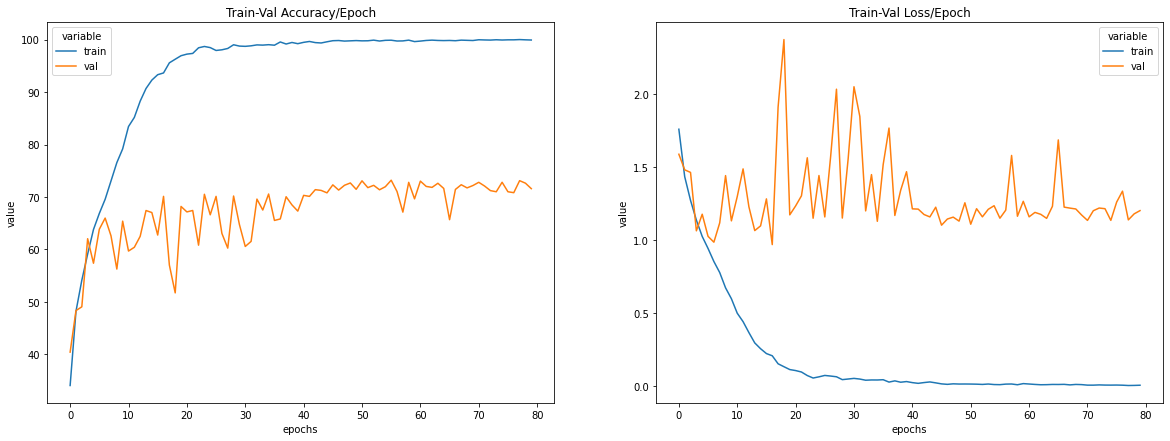

In [ ]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum()/len(correct_pred)
  acc = torch.round(acc*100)
  return acc

accuracy_stats = {'train':[], "val":[]}
loss_stats = {'train':[], "val":[]}
next(model.parameters()).is_cuda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
epochs = 80

print('Begin training...')
start_time = time.time()
print(start_time)
for e in tqdm(range(1, epochs+1)):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device),y_train_batch.to(device)
    optimizer.zero_grad()
    y_train_pred = model(X_train_batch)
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()

  model.eval()
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0

    for X_val_batch, y_val_batch in valid_loader:
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
      y_val_pred = model(X_val_batch)
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(valid_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(valid_loader))

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

print("--- %s seconds ---" % (time.time() - start_time))

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x="epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## **Testing and Confusion Matrix**

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       250
           1       0.90      0.83      0.86       250
           2       0.59      0.54      0.57       250
           3       0.56      0.45      0.50       250
           4       0.70      0.63      0.66       250
           5       0.63      0.64      0.64       250
           6       0.69      0.82      0.75       250
           7       0.68      0.78      0.72       250
           8       0.82      0.83      0.83       250
           9       0.82      0.87      0.84       250

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.71      2500
weighted avg       0.72      0.72      0.71      2500



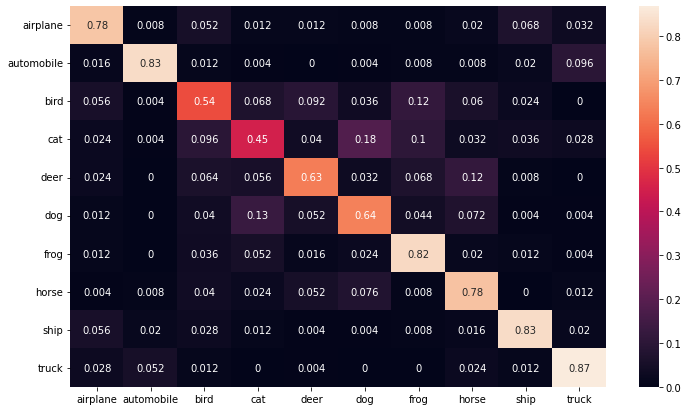

In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

print(classification_report(y_true, y_pred))

# **MiniGoogLeNet architecture with p=0.7**

In [ ]:
# minigooglenet architecture
class miniGoogLeNet(nn.Module):
    def __init__(self, num_class, size, depth):
        super().__init__()
        self.num_class = num_class
        self.size = size
        self.depth = depth
        self.conv = convMod(in_channels=depth, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.inception1 = inceptionMod(in_channels=96, k1x1=32, k3x3=32)
        self.inception2 = inceptionMod(in_channels=64, k1x1=32, k3x3=48)
        self.downsample1 = downsampleMod(in_channels=80, k=80)
        self.inception3 = inceptionMod(in_channels=160, k1x1=112, k3x3=48)
        self.inception4 = inceptionMod(in_channels=160, k1x1=96, k3x3=64)
        self.inception5 = inceptionMod(in_channels=160, k1x1=80, k3x3=80)
        self.inception6 = inceptionMod(in_channels=160, k1x1=48, k3x3=96)
        self.downsample2 = downsampleMod(in_channels=144, k=96)
        self.inception7 = inceptionMod(in_channels=240, k1x1=176, k3x3=160)
        self.inception8 = inceptionMod(in_channels=336, k1x1=176, k3x3=160)
        self.fc = nn.Linear(in_features=336, out_features=num_class)

    def forward(self, x): # input shape is 3x28x28
        x = self.conv(x)  # 96x28x28
        x = self.inception1(x) # 64x28x28
        x = self.inception2(x) # 80x28x28
        x = self.downsample1(x) # 160x13x13
        x = self.inception3(x) # 160x13x13
        x = self.inception4(x) # 160x13x13
        x = self.inception5(x) # 160x13x13
        x = self.inception6(x) # 144x13x13
        x = self.downsample2(x) # 240x6x6
        x = self.inception7(x) # 336x6x6
        x = self.inception8(x) # 336x6x6
        x = F.avg_pool2d(x, kernel_size=7) # 366x1x1
        x = F.dropout(x, p=0.7) # 366x1x1
        x = x.view(x.size(0), -1) # 366
        x = self.fc(x) # 10
        return x

class inceptionMod(nn.Module):
    def __init__(self, in_channels, k1x1, k3x3):
        super(inceptionMod, self).__init__()
        self.conv1 = convMod(in_channels, k1x1, kernel_size=1)
        self.conv3 = convMod(in_channels, k3x3, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        outputs = [conv1, conv3]
        return torch.cat(outputs, 1)

class downsampleMod(nn.Module):
    def __init__(self, in_channels, k):
        super(downsampleMod, self).__init__()
        self.conv = convMod(in_channels, k, kernel_size=3, stride=2)

    def forward(self, x):
        conv3 = self.conv(x)
        maxpool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [conv3, maxpool]
        return torch.cat(outputs, 1)

class convMod(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(convMod, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

model = miniGoogLeNet(len(classes), 32, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# architecture summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
       BatchNorm2d-2           [-1, 96, 32, 32]             192
           convMod-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           3,072
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           convMod-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          27,648
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           convMod-9           [-1, 32, 32, 32]               0
     inceptionMod-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           2,048
      BatchNorm2d-12           [-1, 32, 32, 32]              64
          convMod-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 48,

## **Training and initialization**

Begin training...
1636107467.9288695


  1%|▏         | 1/80 [00:23<31:25, 23.87s/it]

Epoch 001: | Train Loss: 1.82192 | Val Loss: 1.79293 | Train Acc: 31.632 | Val Acc: 36.304


  2%|▎         | 2/80 [00:47<31:00, 23.86s/it]

Epoch 002: | Train Loss: 1.52460 | Val Loss: 1.40603 | Train Acc: 44.284 | Val Acc: 47.704


  4%|▍         | 3/80 [01:11<30:29, 23.76s/it]

Epoch 003: | Train Loss: 1.35422 | Val Loss: 1.34994 | Train Acc: 51.354 | Val Acc: 51.968


  5%|▌         | 4/80 [01:35<30:02, 23.72s/it]

Epoch 004: | Train Loss: 1.23400 | Val Loss: 1.33082 | Train Acc: 55.432 | Val Acc: 53.008


  6%|▋         | 5/80 [01:58<29:38, 23.71s/it]

Epoch 005: | Train Loss: 1.15358 | Val Loss: 1.25513 | Train Acc: 59.172 | Val Acc: 56.416


  8%|▊         | 6/80 [02:22<29:14, 23.71s/it]

Epoch 006: | Train Loss: 1.04570 | Val Loss: 1.21396 | Train Acc: 62.794 | Val Acc: 57.312


  9%|▉         | 7/80 [02:46<28:49, 23.70s/it]

Epoch 007: | Train Loss: 0.96912 | Val Loss: 1.01243 | Train Acc: 65.008 | Val Acc: 63.392


 10%|█         | 8/80 [03:09<28:25, 23.69s/it]

Epoch 008: | Train Loss: 0.88403 | Val Loss: 1.23671 | Train Acc: 68.606 | Val Acc: 58.248


 11%|█▏        | 9/80 [03:33<28:01, 23.68s/it]

Epoch 009: | Train Loss: 0.82036 | Val Loss: 1.47587 | Train Acc: 71.146 | Val Acc: 54.016


 12%|█▎        | 10/80 [03:57<27:38, 23.70s/it]

Epoch 010: | Train Loss: 0.73977 | Val Loss: 1.19707 | Train Acc: 74.554 | Val Acc: 61.504


 14%|█▍        | 11/80 [04:20<27:14, 23.69s/it]

Epoch 011: | Train Loss: 0.66653 | Val Loss: 1.37352 | Train Acc: 76.912 | Val Acc: 58.432


 15%|█▌        | 12/80 [04:44<26:51, 23.70s/it]

Epoch 012: | Train Loss: 0.60068 | Val Loss: 1.04516 | Train Acc: 79.300 | Val Acc: 65.960


 16%|█▋        | 13/80 [05:08<26:26, 23.68s/it]

Epoch 013: | Train Loss: 0.50676 | Val Loss: 1.42504 | Train Acc: 82.398 | Val Acc: 58.664


 18%|█▊        | 14/80 [05:31<26:02, 23.67s/it]

Epoch 014: | Train Loss: 0.46737 | Val Loss: 1.37695 | Train Acc: 84.286 | Val Acc: 59.888


 19%|█▉        | 15/80 [05:55<25:38, 23.68s/it]

Epoch 015: | Train Loss: 0.39888 | Val Loss: 1.44600 | Train Acc: 86.548 | Val Acc: 61.104


 20%|██        | 16/80 [06:19<25:15, 23.68s/it]

Epoch 016: | Train Loss: 0.33454 | Val Loss: 1.19901 | Train Acc: 89.086 | Val Acc: 63.992


 21%|██▏       | 17/80 [06:42<24:52, 23.69s/it]

Epoch 017: | Train Loss: 0.28310 | Val Loss: 1.73105 | Train Acc: 90.912 | Val Acc: 55.008


 22%|██▎       | 18/80 [07:06<24:27, 23.68s/it]

Epoch 018: | Train Loss: 0.26979 | Val Loss: 1.53409 | Train Acc: 91.344 | Val Acc: 62.176


 24%|██▍       | 19/80 [07:30<24:03, 23.67s/it]

Epoch 019: | Train Loss: 0.22570 | Val Loss: 1.34020 | Train Acc: 92.996 | Val Acc: 63.944


 25%|██▌       | 20/80 [07:53<23:39, 23.66s/it]

Epoch 020: | Train Loss: 0.20735 | Val Loss: 1.30903 | Train Acc: 93.516 | Val Acc: 66.256


 26%|██▋       | 21/80 [08:17<23:16, 23.67s/it]

Epoch 021: | Train Loss: 0.18920 | Val Loss: 1.62085 | Train Acc: 94.076 | Val Acc: 61.264


 28%|██▊       | 22/80 [08:41<22:52, 23.67s/it]

Epoch 022: | Train Loss: 0.17302 | Val Loss: 2.26785 | Train Acc: 94.882 | Val Acc: 52.984


 29%|██▉       | 23/80 [09:04<22:29, 23.67s/it]

Epoch 023: | Train Loss: 0.13126 | Val Loss: 1.19733 | Train Acc: 96.436 | Val Acc: 67.936


 30%|███       | 24/80 [09:28<22:05, 23.67s/it]

Epoch 024: | Train Loss: 0.12649 | Val Loss: 1.56881 | Train Acc: 96.320 | Val Acc: 61.264


 31%|███▏      | 25/80 [09:52<21:43, 23.71s/it]

Epoch 025: | Train Loss: 0.10783 | Val Loss: 1.28471 | Train Acc: 96.912 | Val Acc: 66.312


 32%|███▎      | 26/80 [10:16<21:19, 23.69s/it]

Epoch 026: | Train Loss: 0.09867 | Val Loss: 1.18031 | Train Acc: 97.218 | Val Acc: 68.000


 34%|███▍      | 27/80 [10:39<20:54, 23.68s/it]

Epoch 027: | Train Loss: 0.08730 | Val Loss: 2.27451 | Train Acc: 97.588 | Val Acc: 56.384


 35%|███▌      | 28/80 [11:03<20:30, 23.67s/it]

Epoch 028: | Train Loss: 0.09249 | Val Loss: 1.37770 | Train Acc: 97.534 | Val Acc: 65.680


 36%|███▋      | 29/80 [11:26<20:06, 23.66s/it]

Epoch 029: | Train Loss: 0.08446 | Val Loss: 1.20072 | Train Acc: 97.674 | Val Acc: 69.296


 38%|███▊      | 30/80 [11:50<19:42, 23.66s/it]

Epoch 030: | Train Loss: 0.07689 | Val Loss: 1.74174 | Train Acc: 97.892 | Val Acc: 62.816


 39%|███▉      | 31/80 [12:14<19:19, 23.66s/it]

Epoch 031: | Train Loss: 0.07009 | Val Loss: 1.23333 | Train Acc: 98.160 | Val Acc: 68.856


 40%|████      | 32/80 [12:37<18:55, 23.66s/it]

Epoch 032: | Train Loss: 0.06991 | Val Loss: 1.33811 | Train Acc: 97.898 | Val Acc: 66.944


 41%|████▏     | 33/80 [13:01<18:32, 23.68s/it]

Epoch 033: | Train Loss: 0.05951 | Val Loss: 1.20097 | Train Acc: 98.388 | Val Acc: 70.288


 42%|████▎     | 34/80 [13:25<18:08, 23.67s/it]

Epoch 034: | Train Loss: 0.04848 | Val Loss: 1.23781 | Train Acc: 98.752 | Val Acc: 69.312


 44%|████▍     | 35/80 [13:48<17:44, 23.66s/it]

Epoch 035: | Train Loss: 0.04769 | Val Loss: 1.30080 | Train Acc: 98.750 | Val Acc: 69.208


 45%|████▌     | 36/80 [14:12<17:19, 23.64s/it]

Epoch 036: | Train Loss: 0.04231 | Val Loss: 1.26817 | Train Acc: 98.942 | Val Acc: 68.416


 46%|████▋     | 37/80 [14:36<16:55, 23.61s/it]

Epoch 037: | Train Loss: 0.05378 | Val Loss: 1.99184 | Train Acc: 98.508 | Val Acc: 59.776


 48%|████▊     | 38/80 [14:59<16:32, 23.63s/it]

Epoch 038: | Train Loss: 0.05330 | Val Loss: 1.40340 | Train Acc: 98.448 | Val Acc: 67.232


 49%|████▉     | 39/80 [15:23<16:09, 23.64s/it]

Epoch 039: | Train Loss: 0.03119 | Val Loss: 1.22871 | Train Acc: 99.256 | Val Acc: 69.352


 50%|█████     | 40/80 [15:47<15:46, 23.67s/it]

Epoch 040: | Train Loss: 0.04475 | Val Loss: 1.18415 | Train Acc: 98.808 | Val Acc: 69.896


 51%|█████▏    | 41/80 [16:10<15:22, 23.66s/it]

Epoch 041: | Train Loss: 0.04090 | Val Loss: 1.24677 | Train Acc: 98.944 | Val Acc: 69.408


 52%|█████▎    | 42/80 [16:34<14:59, 23.67s/it]

Epoch 042: | Train Loss: 0.04113 | Val Loss: 1.31876 | Train Acc: 98.952 | Val Acc: 69.288


 54%|█████▍    | 43/80 [16:58<14:35, 23.65s/it]

Epoch 043: | Train Loss: 0.03671 | Val Loss: 1.23040 | Train Acc: 99.158 | Val Acc: 69.488


 55%|█████▌    | 44/80 [17:21<14:11, 23.65s/it]

Epoch 044: | Train Loss: 0.03468 | Val Loss: 1.28069 | Train Acc: 99.172 | Val Acc: 70.048


 56%|█████▋    | 45/80 [17:45<13:48, 23.68s/it]

Epoch 045: | Train Loss: 0.03774 | Val Loss: 1.24269 | Train Acc: 98.906 | Val Acc: 69.520


 57%|█████▊    | 46/80 [18:09<13:24, 23.67s/it]

Epoch 046: | Train Loss: 0.03318 | Val Loss: 1.57565 | Train Acc: 99.220 | Val Acc: 65.776


 59%|█████▉    | 47/80 [18:32<13:01, 23.67s/it]

Epoch 047: | Train Loss: 0.02927 | Val Loss: 1.31394 | Train Acc: 99.316 | Val Acc: 70.200


 60%|██████    | 48/80 [18:56<12:37, 23.67s/it]

Epoch 048: | Train Loss: 0.02352 | Val Loss: 1.16835 | Train Acc: 99.448 | Val Acc: 70.280


 61%|██████▏   | 49/80 [19:20<12:13, 23.67s/it]

Epoch 049: | Train Loss: 0.03318 | Val Loss: 1.44546 | Train Acc: 99.160 | Val Acc: 67.440


 62%|██████▎   | 50/80 [19:43<11:49, 23.66s/it]

Epoch 050: | Train Loss: 0.03152 | Val Loss: 1.30301 | Train Acc: 99.184 | Val Acc: 70.400


 64%|██████▍   | 51/80 [20:07<11:25, 23.65s/it]

Epoch 051: | Train Loss: 0.02679 | Val Loss: 1.27397 | Train Acc: 99.324 | Val Acc: 69.424


 65%|██████▌   | 52/80 [20:31<11:02, 23.67s/it]

Epoch 052: | Train Loss: 0.01642 | Val Loss: 1.29443 | Train Acc: 99.688 | Val Acc: 70.432


 66%|██████▋   | 53/80 [20:54<10:38, 23.67s/it]

Epoch 053: | Train Loss: 0.02583 | Val Loss: 1.35769 | Train Acc: 99.350 | Val Acc: 70.152


 68%|██████▊   | 54/80 [21:18<10:15, 23.67s/it]

Epoch 054: | Train Loss: 0.02206 | Val Loss: 1.21679 | Train Acc: 99.460 | Val Acc: 71.752


 69%|██████▉   | 55/80 [21:42<09:51, 23.64s/it]

Epoch 055: | Train Loss: 0.01573 | Val Loss: 1.41768 | Train Acc: 99.772 | Val Acc: 69.400


 70%|███████   | 56/80 [22:05<09:27, 23.65s/it]

Epoch 056: | Train Loss: 0.01800 | Val Loss: 1.27202 | Train Acc: 99.532 | Val Acc: 71.192


 71%|███████▏  | 57/80 [22:29<09:03, 23.63s/it]

Epoch 057: | Train Loss: 0.01744 | Val Loss: 1.48498 | Train Acc: 99.664 | Val Acc: 69.072


 72%|███████▎  | 58/80 [22:52<08:39, 23.61s/it]

Epoch 058: | Train Loss: 0.01811 | Val Loss: 1.26963 | Train Acc: 99.580 | Val Acc: 71.624


 74%|███████▍  | 59/80 [23:16<08:15, 23.59s/it]

Epoch 059: | Train Loss: 0.02282 | Val Loss: 1.29340 | Train Acc: 99.374 | Val Acc: 69.480


 75%|███████▌  | 60/80 [23:39<07:51, 23.58s/it]

Epoch 060: | Train Loss: 0.02074 | Val Loss: 1.30412 | Train Acc: 99.436 | Val Acc: 70.848


 76%|███████▋  | 61/80 [24:03<07:30, 23.69s/it]

Epoch 061: | Train Loss: 0.02408 | Val Loss: 1.40665 | Train Acc: 99.352 | Val Acc: 70.480


 78%|███████▊  | 62/80 [24:27<07:07, 23.74s/it]

Epoch 062: | Train Loss: 0.02020 | Val Loss: 1.45552 | Train Acc: 99.472 | Val Acc: 67.936


 79%|███████▉  | 63/80 [24:51<06:44, 23.78s/it]

Epoch 063: | Train Loss: 0.02157 | Val Loss: 1.25902 | Train Acc: 99.520 | Val Acc: 69.360


 80%|████████  | 64/80 [25:15<06:20, 23.79s/it]

Epoch 064: | Train Loss: 0.01736 | Val Loss: 1.24344 | Train Acc: 99.568 | Val Acc: 70.536


 81%|████████▏ | 65/80 [25:39<05:57, 23.81s/it]

Epoch 065: | Train Loss: 0.01599 | Val Loss: 1.32410 | Train Acc: 99.640 | Val Acc: 69.976


 82%|████████▎ | 66/80 [26:03<05:33, 23.82s/it]

Epoch 066: | Train Loss: 0.01609 | Val Loss: 1.35007 | Train Acc: 99.604 | Val Acc: 70.704


 84%|████████▍ | 67/80 [26:26<05:09, 23.83s/it]

Epoch 067: | Train Loss: 0.01703 | Val Loss: 1.28128 | Train Acc: 99.568 | Val Acc: 71.280


 85%|████████▌ | 68/80 [26:50<04:46, 23.86s/it]

Epoch 068: | Train Loss: 0.01606 | Val Loss: 1.28573 | Train Acc: 99.640 | Val Acc: 71.808


 86%|████████▋ | 69/80 [27:14<04:22, 23.86s/it]

Epoch 069: | Train Loss: 0.01363 | Val Loss: 1.24631 | Train Acc: 99.700 | Val Acc: 71.488


 88%|████████▊ | 70/80 [27:38<03:58, 23.85s/it]

Epoch 070: | Train Loss: 0.01274 | Val Loss: 1.27791 | Train Acc: 99.724 | Val Acc: 71.496


 89%|████████▉ | 71/80 [28:02<03:34, 23.86s/it]

Epoch 071: | Train Loss: 0.00989 | Val Loss: 1.21282 | Train Acc: 99.832 | Val Acc: 72.712


 90%|█████████ | 72/80 [28:26<03:10, 23.85s/it]

Epoch 072: | Train Loss: 0.01342 | Val Loss: 1.27160 | Train Acc: 99.724 | Val Acc: 71.200


 91%|█████████▏| 73/80 [28:50<02:47, 23.86s/it]

Epoch 073: | Train Loss: 0.00887 | Val Loss: 1.25177 | Train Acc: 99.856 | Val Acc: 71.296


 92%|█████████▎| 74/80 [29:14<02:23, 23.88s/it]

Epoch 074: | Train Loss: 0.01358 | Val Loss: 1.28077 | Train Acc: 99.628 | Val Acc: 70.880


 94%|█████████▍| 75/80 [29:38<01:59, 23.90s/it]

Epoch 075: | Train Loss: 0.01490 | Val Loss: 1.37476 | Train Acc: 99.652 | Val Acc: 69.968


 95%|█████████▌| 76/80 [30:01<01:35, 23.89s/it]

Epoch 076: | Train Loss: 0.01566 | Val Loss: 1.32474 | Train Acc: 99.568 | Val Acc: 70.848


 96%|█████████▋| 77/80 [30:25<01:11, 23.88s/it]

Epoch 077: | Train Loss: 0.01211 | Val Loss: 1.32096 | Train Acc: 99.748 | Val Acc: 70.760


 98%|█████████▊| 78/80 [30:49<00:47, 23.88s/it]

Epoch 078: | Train Loss: 0.01458 | Val Loss: 1.29422 | Train Acc: 99.700 | Val Acc: 70.920


 99%|█████████▉| 79/80 [31:13<00:23, 23.87s/it]

Epoch 079: | Train Loss: 0.01536 | Val Loss: 1.28160 | Train Acc: 99.616 | Val Acc: 71.696


100%|██████████| 80/80 [31:37<00:00, 23.72s/it]

Epoch 080: | Train Loss: 0.01845 | Val Loss: 1.28105 | Train Acc: 99.592 | Val Acc: 70.600
--- 1897.381198167801 seconds ---


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

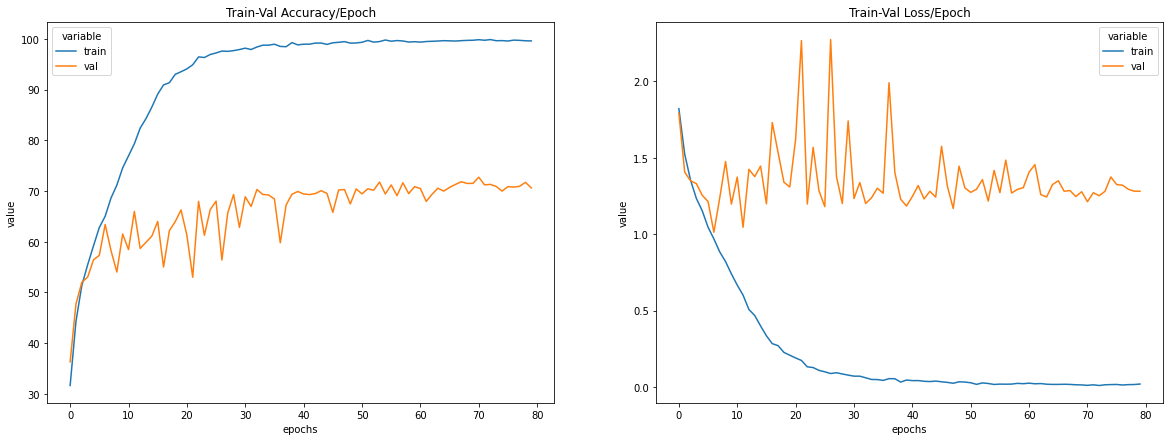

In [ ]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum()/len(correct_pred)
  acc = torch.round(acc*100)
  return acc

accuracy_stats = {'train':[], "val":[]}
loss_stats = {'train':[], "val":[]}
next(model.parameters()).is_cuda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
epochs = 80

print('Begin training...')
start_time = time.time()
print(start_time)
for e in tqdm(range(1, epochs+1)):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device),y_train_batch.to(device)
    optimizer.zero_grad()
    y_train_pred = model(X_train_batch)
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()

  model.eval()
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0

    for X_val_batch, y_val_batch in valid_loader:
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
      y_val_pred = model(X_val_batch)
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(valid_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(valid_loader))

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

print("--- %s seconds ---" % (time.time() - start_time))

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x="epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## **Testing and Confusion Matrix**

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       250
           1       0.82      0.82      0.82       250
           2       0.52      0.58      0.55       250
           3       0.56      0.44      0.49       250
           4       0.66      0.56      0.60       250
           5       0.57      0.65      0.61       250
           6       0.67      0.78      0.72       250
           7       0.75      0.69      0.72       250
           8       0.84      0.81      0.83       250
           9       0.83      0.83      0.83       250

    accuracy                           0.69      2500
   macro avg       0.69      0.69      0.69      2500
weighted avg       0.69      0.69      0.69      2500



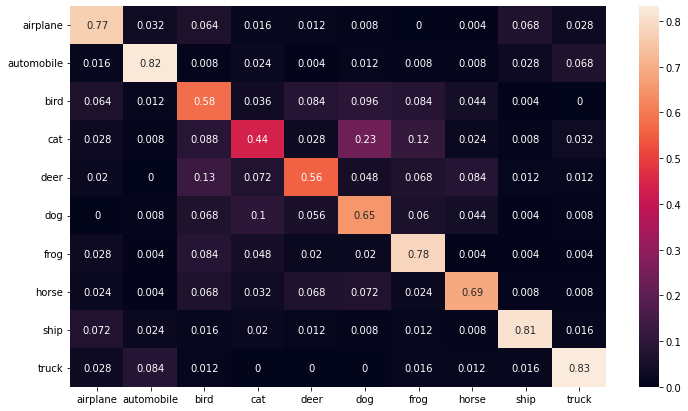

In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

print(classification_report(y_true, y_pred))

# **MiniGoogLeNet architecture with p=0.9**

In [ ]:
# minigooglenet architecture
class miniGoogLeNet(nn.Module):
    def __init__(self, num_class, size, depth):
        super().__init__()
        self.num_class = num_class
        self.size = size
        self.depth = depth
        self.conv = convMod(in_channels=depth, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.inception1 = inceptionMod(in_channels=96, k1x1=32, k3x3=32)
        self.inception2 = inceptionMod(in_channels=64, k1x1=32, k3x3=48)
        self.downsample1 = downsampleMod(in_channels=80, k=80)
        self.inception3 = inceptionMod(in_channels=160, k1x1=112, k3x3=48)
        self.inception4 = inceptionMod(in_channels=160, k1x1=96, k3x3=64)
        self.inception5 = inceptionMod(in_channels=160, k1x1=80, k3x3=80)
        self.inception6 = inceptionMod(in_channels=160, k1x1=48, k3x3=96)
        self.downsample2 = downsampleMod(in_channels=144, k=96)
        self.inception7 = inceptionMod(in_channels=240, k1x1=176, k3x3=160)
        self.inception8 = inceptionMod(in_channels=336, k1x1=176, k3x3=160)
        self.fc = nn.Linear(in_features=336, out_features=num_class)

    def forward(self, x): # input shape is 3x28x28
        x = self.conv(x)  # 96x28x28
        x = self.inception1(x) # 64x28x28
        x = self.inception2(x) # 80x28x28
        x = self.downsample1(x) # 160x13x13
        x = self.inception3(x) # 160x13x13
        x = self.inception4(x) # 160x13x13
        x = self.inception5(x) # 160x13x13
        x = self.inception6(x) # 144x13x13
        x = self.downsample2(x) # 240x6x6
        x = self.inception7(x) # 336x6x6
        x = self.inception8(x) # 336x6x6
        x = F.avg_pool2d(x, kernel_size=7) # 366x1x1
        x = F.dropout(x, p=0.9) # 366x1x1
        x = x.view(x.size(0), -1) # 366
        x = self.fc(x) # 10
        return x

class inceptionMod(nn.Module):
    def __init__(self, in_channels, k1x1, k3x3):
        super(inceptionMod, self).__init__()
        self.conv1 = convMod(in_channels, k1x1, kernel_size=1)
        self.conv3 = convMod(in_channels, k3x3, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        outputs = [conv1, conv3]
        return torch.cat(outputs, 1)

class downsampleMod(nn.Module):
    def __init__(self, in_channels, k):
        super(downsampleMod, self).__init__()
        self.conv = convMod(in_channels, k, kernel_size=3, stride=2)

    def forward(self, x):
        conv3 = self.conv(x)
        maxpool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [conv3, maxpool]
        return torch.cat(outputs, 1)

class convMod(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(convMod, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

model = miniGoogLeNet(len(classes), 32, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# architecture summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
       BatchNorm2d-2           [-1, 96, 32, 32]             192
           convMod-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           3,072
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           convMod-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          27,648
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           convMod-9           [-1, 32, 32, 32]               0
     inceptionMod-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           2,048
      BatchNorm2d-12           [-1, 32, 32, 32]              64
          convMod-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 48,

## **Training and initialization**

Begin training...
1636109371.5463479


  1%|▏         | 1/80 [00:23<31:30, 23.93s/it]

Epoch 001: | Train Loss: 2.09166 | Val Loss: 1.86899 | Train Acc: 22.968 | Val Acc: 29.832


  2%|▎         | 2/80 [00:47<31:03, 23.89s/it]

Epoch 002: | Train Loss: 1.81777 | Val Loss: 1.69298 | Train Acc: 31.574 | Val Acc: 36.064


  4%|▍         | 3/80 [01:11<30:37, 23.86s/it]

Epoch 003: | Train Loss: 1.67715 | Val Loss: 1.63272 | Train Acc: 37.796 | Val Acc: 39.480


  5%|▌         | 4/80 [01:35<30:14, 23.87s/it]

Epoch 004: | Train Loss: 1.56980 | Val Loss: 1.59889 | Train Acc: 41.836 | Val Acc: 41.248


  6%|▋         | 5/80 [01:59<29:48, 23.85s/it]

Epoch 005: | Train Loss: 1.51884 | Val Loss: 1.55193 | Train Acc: 44.940 | Val Acc: 44.080


  8%|▊         | 6/80 [02:23<29:23, 23.83s/it]

Epoch 006: | Train Loss: 1.44005 | Val Loss: 1.49010 | Train Acc: 47.336 | Val Acc: 45.232


  9%|▉         | 7/80 [02:46<28:55, 23.78s/it]

Epoch 007: | Train Loss: 1.34978 | Val Loss: 1.64338 | Train Acc: 50.630 | Val Acc: 45.296


 10%|█         | 8/80 [03:10<28:30, 23.76s/it]

Epoch 008: | Train Loss: 1.28296 | Val Loss: 1.36493 | Train Acc: 52.438 | Val Acc: 51.016


 11%|█▏        | 9/80 [03:34<28:10, 23.81s/it]

Epoch 009: | Train Loss: 1.23969 | Val Loss: 1.28397 | Train Acc: 55.010 | Val Acc: 54.288


 12%|█▎        | 10/80 [03:58<27:48, 23.83s/it]

Epoch 010: | Train Loss: 1.17474 | Val Loss: 1.76804 | Train Acc: 57.586 | Val Acc: 45.120


 14%|█▍        | 11/80 [04:22<27:25, 23.85s/it]

Epoch 011: | Train Loss: 1.09819 | Val Loss: 1.44535 | Train Acc: 60.476 | Val Acc: 51.568


 15%|█▌        | 12/80 [04:46<27:02, 23.86s/it]

Epoch 012: | Train Loss: 1.05026 | Val Loss: 1.30511 | Train Acc: 61.988 | Val Acc: 56.328


 16%|█▋        | 13/80 [05:09<26:36, 23.83s/it]

Epoch 013: | Train Loss: 1.01452 | Val Loss: 1.23185 | Train Acc: 63.730 | Val Acc: 57.992


 18%|█▊        | 14/80 [05:33<26:10, 23.80s/it]

Epoch 014: | Train Loss: 0.95036 | Val Loss: 1.35425 | Train Acc: 65.678 | Val Acc: 55.288


 19%|█▉        | 15/80 [05:57<25:47, 23.81s/it]

Epoch 015: | Train Loss: 0.87673 | Val Loss: 1.22758 | Train Acc: 68.800 | Val Acc: 58.696


 20%|██        | 16/80 [06:21<25:24, 23.82s/it]

Epoch 016: | Train Loss: 0.86903 | Val Loss: 1.38487 | Train Acc: 68.852 | Val Acc: 55.872


 21%|██▏       | 17/80 [06:45<25:00, 23.82s/it]

Epoch 017: | Train Loss: 0.80126 | Val Loss: 1.44289 | Train Acc: 71.446 | Val Acc: 56.864


 22%|██▎       | 18/80 [07:08<24:34, 23.78s/it]

Epoch 018: | Train Loss: 0.72421 | Val Loss: 1.72480 | Train Acc: 74.138 | Val Acc: 53.672


 24%|██▍       | 19/80 [07:32<24:08, 23.74s/it]

Epoch 019: | Train Loss: 0.69133 | Val Loss: 1.46695 | Train Acc: 75.350 | Val Acc: 57.640


 25%|██▌       | 20/80 [07:56<23:44, 23.75s/it]

Epoch 020: | Train Loss: 0.63851 | Val Loss: 1.24818 | Train Acc: 77.318 | Val Acc: 60.624


 26%|██▋       | 21/80 [08:19<23:22, 23.78s/it]

Epoch 021: | Train Loss: 0.61015 | Val Loss: 1.11231 | Train Acc: 78.580 | Val Acc: 62.000


 28%|██▊       | 22/80 [08:43<23:02, 23.83s/it]

Epoch 022: | Train Loss: 0.51729 | Val Loss: 2.32924 | Train Acc: 82.056 | Val Acc: 47.952


 29%|██▉       | 23/80 [09:07<22:38, 23.83s/it]

Epoch 023: | Train Loss: 0.49346 | Val Loss: 1.90769 | Train Acc: 83.058 | Val Acc: 54.024


 30%|███       | 24/80 [09:31<22:15, 23.85s/it]

Epoch 024: | Train Loss: 0.43601 | Val Loss: 2.08981 | Train Acc: 85.130 | Val Acc: 52.432


 31%|███▏      | 25/80 [09:55<21:52, 23.86s/it]

Epoch 025: | Train Loss: 0.42986 | Val Loss: 1.96958 | Train Acc: 85.170 | Val Acc: 54.456


 32%|███▎      | 26/80 [10:19<21:27, 23.84s/it]

Epoch 026: | Train Loss: 0.40222 | Val Loss: 1.66357 | Train Acc: 85.984 | Val Acc: 55.408


 34%|███▍      | 27/80 [10:43<21:03, 23.84s/it]

Epoch 027: | Train Loss: 0.36920 | Val Loss: 1.84821 | Train Acc: 87.450 | Val Acc: 55.856


 35%|███▌      | 28/80 [11:06<20:38, 23.81s/it]

Epoch 028: | Train Loss: 0.39206 | Val Loss: 2.88862 | Train Acc: 86.846 | Val Acc: 45.408


 36%|███▋      | 29/80 [11:30<20:11, 23.75s/it]

Epoch 029: | Train Loss: 0.33613 | Val Loss: 1.95278 | Train Acc: 89.092 | Val Acc: 55.336


 38%|███▊      | 30/80 [11:54<19:46, 23.74s/it]

Epoch 030: | Train Loss: 0.34198 | Val Loss: 2.23499 | Train Acc: 88.788 | Val Acc: 51.264


 39%|███▉      | 31/80 [12:18<19:23, 23.74s/it]

Epoch 031: | Train Loss: 0.29050 | Val Loss: 1.45340 | Train Acc: 90.782 | Val Acc: 61.792


 40%|████      | 32/80 [12:41<18:57, 23.70s/it]

Epoch 032: | Train Loss: 0.24038 | Val Loss: 1.49448 | Train Acc: 92.156 | Val Acc: 61.728


 41%|████▏     | 33/80 [13:05<18:32, 23.66s/it]

Epoch 033: | Train Loss: 0.23214 | Val Loss: 1.26585 | Train Acc: 92.946 | Val Acc: 64.720


 42%|████▎     | 34/80 [13:28<18:06, 23.62s/it]

Epoch 034: | Train Loss: 0.22044 | Val Loss: 1.59282 | Train Acc: 93.098 | Val Acc: 61.336


 44%|████▍     | 35/80 [13:52<17:41, 23.60s/it]

Epoch 035: | Train Loss: 0.23169 | Val Loss: 1.59119 | Train Acc: 92.762 | Val Acc: 62.432


 45%|████▌     | 36/80 [14:15<17:18, 23.59s/it]

Epoch 036: | Train Loss: 0.23384 | Val Loss: 1.85578 | Train Acc: 92.272 | Val Acc: 60.344


 46%|████▋     | 37/80 [14:39<16:54, 23.59s/it]

Epoch 037: | Train Loss: 0.23182 | Val Loss: 1.78198 | Train Acc: 92.762 | Val Acc: 60.672


 48%|████▊     | 38/80 [15:03<16:31, 23.61s/it]

Epoch 038: | Train Loss: 0.18437 | Val Loss: 1.73844 | Train Acc: 94.336 | Val Acc: 62.456


 49%|████▉     | 39/80 [15:26<16:08, 23.61s/it]

Epoch 039: | Train Loss: 0.16137 | Val Loss: 1.60919 | Train Acc: 95.320 | Val Acc: 64.312


 50%|█████     | 40/80 [15:50<15:47, 23.69s/it]

Epoch 040: | Train Loss: 0.16187 | Val Loss: 1.90187 | Train Acc: 95.174 | Val Acc: 60.768


 51%|█████▏    | 41/80 [16:14<15:26, 23.74s/it]

Epoch 041: | Train Loss: 0.16283 | Val Loss: 2.20519 | Train Acc: 95.002 | Val Acc: 56.128


 52%|█████▎    | 42/80 [16:38<15:03, 23.76s/it]

Epoch 042: | Train Loss: 0.14655 | Val Loss: 1.55673 | Train Acc: 95.732 | Val Acc: 64.872


 54%|█████▍    | 43/80 [17:02<14:40, 23.79s/it]

Epoch 043: | Train Loss: 0.13551 | Val Loss: 1.62705 | Train Acc: 95.860 | Val Acc: 62.360


 55%|█████▌    | 44/80 [17:26<14:17, 23.83s/it]

Epoch 044: | Train Loss: 0.13248 | Val Loss: 1.57392 | Train Acc: 96.114 | Val Acc: 63.688


 56%|█████▋    | 45/80 [17:49<13:54, 23.84s/it]

Epoch 045: | Train Loss: 0.14569 | Val Loss: 1.56244 | Train Acc: 95.614 | Val Acc: 63.480


 57%|█████▊    | 46/80 [18:13<13:32, 23.88s/it]

Epoch 046: | Train Loss: 0.13710 | Val Loss: 1.60746 | Train Acc: 95.774 | Val Acc: 65.112


 59%|█████▉    | 47/80 [18:37<13:08, 23.90s/it]

Epoch 047: | Train Loss: 0.14033 | Val Loss: 1.61824 | Train Acc: 95.798 | Val Acc: 64.712


 60%|██████    | 48/80 [19:01<12:43, 23.86s/it]

Epoch 048: | Train Loss: 0.12574 | Val Loss: 1.75748 | Train Acc: 96.276 | Val Acc: 62.400


 61%|██████▏   | 49/80 [19:25<12:18, 23.82s/it]

Epoch 049: | Train Loss: 0.11605 | Val Loss: 1.60050 | Train Acc: 96.632 | Val Acc: 63.760


 62%|██████▎   | 50/80 [19:49<11:54, 23.80s/it]

Epoch 050: | Train Loss: 0.12643 | Val Loss: 2.22171 | Train Acc: 96.354 | Val Acc: 57.328


 64%|██████▍   | 51/80 [20:12<11:30, 23.81s/it]

Epoch 051: | Train Loss: 0.12121 | Val Loss: 1.59112 | Train Acc: 96.416 | Val Acc: 64.696


 65%|██████▌   | 52/80 [20:36<11:06, 23.80s/it]

Epoch 052: | Train Loss: 0.12186 | Val Loss: 1.99466 | Train Acc: 96.392 | Val Acc: 59.320


 66%|██████▋   | 53/80 [21:00<10:42, 23.79s/it]

Epoch 053: | Train Loss: 0.11277 | Val Loss: 1.78055 | Train Acc: 96.762 | Val Acc: 62.960


 68%|██████▊   | 54/80 [21:24<10:19, 23.81s/it]

Epoch 054: | Train Loss: 0.10301 | Val Loss: 1.82104 | Train Acc: 97.108 | Val Acc: 63.192


 69%|██████▉   | 55/80 [21:48<09:54, 23.79s/it]

Epoch 055: | Train Loss: 0.08163 | Val Loss: 1.53918 | Train Acc: 97.722 | Val Acc: 65.464


 70%|███████   | 56/80 [22:11<09:30, 23.78s/it]

Epoch 056: | Train Loss: 0.08852 | Val Loss: 1.61920 | Train Acc: 97.586 | Val Acc: 66.224


 71%|███████▏  | 57/80 [22:35<09:06, 23.78s/it]

Epoch 057: | Train Loss: 0.08552 | Val Loss: 1.59031 | Train Acc: 97.510 | Val Acc: 64.992


 72%|███████▎  | 58/80 [22:59<08:42, 23.76s/it]

Epoch 058: | Train Loss: 0.08548 | Val Loss: 1.56676 | Train Acc: 97.706 | Val Acc: 65.208


 74%|███████▍  | 59/80 [23:22<08:18, 23.74s/it]

Epoch 059: | Train Loss: 0.09605 | Val Loss: 1.59357 | Train Acc: 97.258 | Val Acc: 65.616


 75%|███████▌  | 60/80 [23:46<07:54, 23.72s/it]

Epoch 060: | Train Loss: 0.08215 | Val Loss: 1.51960 | Train Acc: 97.626 | Val Acc: 66.152


 76%|███████▋  | 61/80 [24:10<07:30, 23.72s/it]

Epoch 061: | Train Loss: 0.10112 | Val Loss: 1.81744 | Train Acc: 97.108 | Val Acc: 63.880


 78%|███████▊  | 62/80 [24:34<07:07, 23.74s/it]

Epoch 062: | Train Loss: 0.08483 | Val Loss: 1.63174 | Train Acc: 97.624 | Val Acc: 63.096


 79%|███████▉  | 63/80 [24:57<06:43, 23.73s/it]

Epoch 063: | Train Loss: 0.07050 | Val Loss: 1.51893 | Train Acc: 98.048 | Val Acc: 66.592


 80%|████████  | 64/80 [25:21<06:19, 23.75s/it]

Epoch 064: | Train Loss: 0.07912 | Val Loss: 1.46762 | Train Acc: 97.788 | Val Acc: 66.840


 81%|████████▏ | 65/80 [25:45<05:56, 23.76s/it]

Epoch 065: | Train Loss: 0.07396 | Val Loss: 1.45469 | Train Acc: 98.048 | Val Acc: 66.976


 82%|████████▎ | 66/80 [26:09<05:32, 23.74s/it]

Epoch 066: | Train Loss: 0.06560 | Val Loss: 1.59758 | Train Acc: 98.230 | Val Acc: 65.768


 84%|████████▍ | 67/80 [26:32<05:08, 23.71s/it]

Epoch 067: | Train Loss: 0.06500 | Val Loss: 1.52240 | Train Acc: 98.314 | Val Acc: 67.320


 85%|████████▌ | 68/80 [26:56<04:44, 23.70s/it]

Epoch 068: | Train Loss: 0.07020 | Val Loss: 1.77200 | Train Acc: 98.032 | Val Acc: 63.776


 86%|████████▋ | 69/80 [27:20<04:20, 23.68s/it]

Epoch 069: | Train Loss: 0.05926 | Val Loss: 1.55907 | Train Acc: 98.248 | Val Acc: 66.344


 88%|████████▊ | 70/80 [27:43<03:56, 23.69s/it]

Epoch 070: | Train Loss: 0.06051 | Val Loss: 1.40618 | Train Acc: 98.192 | Val Acc: 68.680


 89%|████████▉ | 71/80 [28:07<03:33, 23.70s/it]

Epoch 071: | Train Loss: 0.05527 | Val Loss: 1.49597 | Train Acc: 98.642 | Val Acc: 66.032


 90%|█████████ | 72/80 [28:31<03:09, 23.70s/it]

Epoch 072: | Train Loss: 0.04867 | Val Loss: 1.41818 | Train Acc: 98.800 | Val Acc: 68.120


 91%|█████████▏| 73/80 [28:55<02:46, 23.72s/it]

Epoch 073: | Train Loss: 0.05660 | Val Loss: 1.60201 | Train Acc: 98.666 | Val Acc: 67.616


 92%|█████████▎| 74/80 [29:18<02:22, 23.72s/it]

Epoch 074: | Train Loss: 0.05268 | Val Loss: 1.79728 | Train Acc: 98.592 | Val Acc: 62.928


 94%|█████████▍| 75/80 [29:42<01:58, 23.71s/it]

Epoch 075: | Train Loss: 0.05835 | Val Loss: 1.65203 | Train Acc: 98.374 | Val Acc: 65.360


 95%|█████████▌| 76/80 [30:06<01:34, 23.71s/it]

Epoch 076: | Train Loss: 0.04841 | Val Loss: 1.60447 | Train Acc: 98.614 | Val Acc: 65.968


 96%|█████████▋| 77/80 [30:29<01:11, 23.70s/it]

Epoch 077: | Train Loss: 0.04447 | Val Loss: 1.56586 | Train Acc: 98.836 | Val Acc: 66.048


 98%|█████████▊| 78/80 [30:53<00:47, 23.73s/it]

Epoch 078: | Train Loss: 0.04682 | Val Loss: 1.49712 | Train Acc: 98.762 | Val Acc: 68.656


 99%|█████████▉| 79/80 [31:17<00:23, 23.72s/it]

Epoch 079: | Train Loss: 0.04923 | Val Loss: 1.57508 | Train Acc: 98.758 | Val Acc: 66.392


100%|██████████| 80/80 [31:41<00:00, 23.76s/it]

Epoch 080: | Train Loss: 0.04755 | Val Loss: 1.64515 | Train Acc: 98.664 | Val Acc: 66.256
--- 1901.1502170562744 seconds ---


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

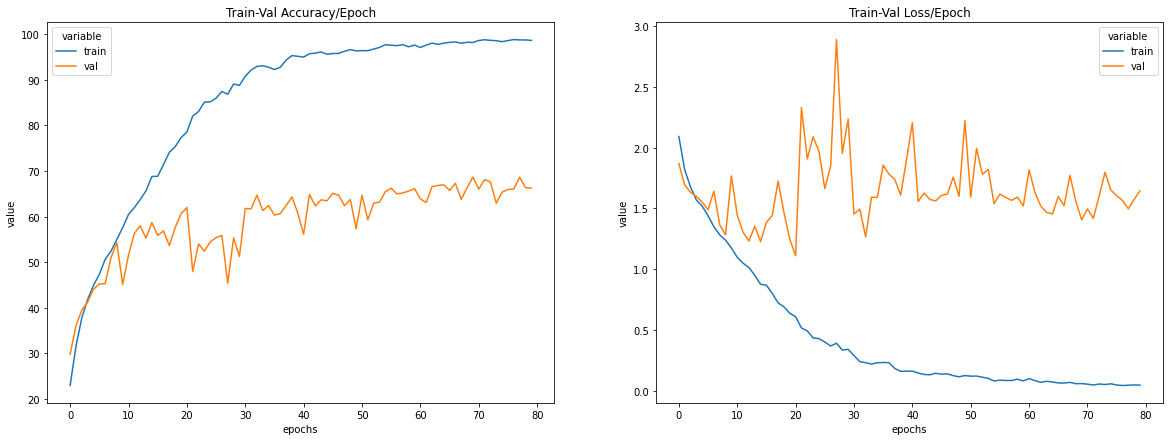

In [ ]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum()/len(correct_pred)
  acc = torch.round(acc*100)
  return acc

accuracy_stats = {'train':[], "val":[]}
loss_stats = {'train':[], "val":[]}
next(model.parameters()).is_cuda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
epochs = 80

print('Begin training...')
start_time = time.time()
print(start_time)
for e in tqdm(range(1, epochs+1)):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device),y_train_batch.to(device)
    optimizer.zero_grad()
    y_train_pred = model(X_train_batch)
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()

  model.eval()
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0

    for X_val_batch, y_val_batch in valid_loader:
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
      y_val_pred = model(X_val_batch)
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(valid_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(valid_loader))

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

print("--- %s seconds ---" % (time.time() - start_time))

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x="epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## **Testing and Confusion Matrix**

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       250
           1       0.81      0.80      0.80       250
           2       0.46      0.55      0.50       250
           3       0.52      0.34      0.41       250
           4       0.55      0.58      0.56       250
           5       0.56      0.59      0.57       250
           6       0.60      0.80      0.69       250
           7       0.70      0.69      0.70       250
           8       0.83      0.79      0.81       250
           9       0.79      0.76      0.77       250

    accuracy                           0.66      2500
   macro avg       0.66      0.66      0.66      2500
weighted avg       0.66      0.66      0.66      2500



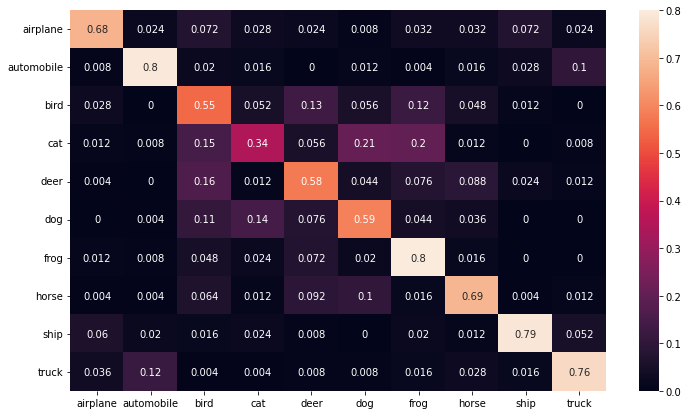

In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

print(classification_report(y_true, y_pred))

# **MiniGoogLeNet with full-Cifar10**

In [ ]:
# Preprocessing
num_workers = 0
batch_size = 16
valid_size = 0.2

transform = transforms.Compose([
                               transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.4914, 0.4822, 0.4465),(0.247, 0.243, 0.261))
])

class cifarTrain(datasets.CIFAR10):
    def __init__(self, path, transforms, train=True):
        super().__init__(path, train, download=True)
        self.transforms = transforms
        self.n_images_per_class = 5000
        self.n_classes = 10
        self.new2old_indices = self.create_idx_mapping()

    def create_idx_mapping(self):
        label2idx = defaultdict(lambda: deque(maxlen=self.n_images_per_class))
        for original_idx in range(super().__len__()):
            _, label = super().__getitem__(original_idx)
            label2idx[label].append(original_idx)

        old_idxs = set(itertools.chain(*label2idx.values()))
        new2old_indices = {}
        for new_idx, old_idx in enumerate(old_idxs):
            new2old_indices[new_idx] = old_idx

        return new2old_indices

    def __len__(self):
        return len(self.new2old_indices)

    def __getitem__(self, index):
        index = self.new2old_indices[index]
        im, label = super().__getitem__(index)
        return self.transforms(im), label

class cifarTest(datasets.CIFAR10):
    def __init__(self, path, transforms, train=False):
        super().__init__(path, train, download=True)
        self.transforms = transforms
        self.n_images_per_class = 1000
        self.n_classes = 10
        self.new2old_indices = self.create_idx_mapping()

    def create_idx_mapping(self):
        label2idx = defaultdict(lambda: deque(maxlen=self.n_images_per_class))
        for original_idx in range(super().__len__()):
            _, label = super().__getitem__(original_idx)
            label2idx[label].append(original_idx)

        old_idxs = set(itertools.chain(*label2idx.values()))
        new2old_indices = {}
        for new_idx, old_idx in enumerate(old_idxs):
            new2old_indices[new_idx] = old_idx

        return new2old_indices

    def __len__(self):
        return len(self.new2old_indices)

    def __getitem__(self, index):
        index = self.new2old_indices[index]
        im, label = super().__getitem__(index)
        return self.transforms(im), label

train_data = cifarTrain('data', transform)
test_data = cifarTest('data', transform)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_id, valid_id = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_id)
valid_sampler = SubsetRandomSampler(valid_id)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# minigooglenet architecture
class miniGoogLeNet(nn.Module):
    def __init__(self, num_class, size, depth):
        super().__init__()
        self.num_class = num_class
        self.size = size
        self.depth = depth
        self.conv = convMod(in_channels=depth, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.inception1 = inceptionMod(in_channels=96, k1x1=32, k3x3=32)
        self.inception2 = inceptionMod(in_channels=64, k1x1=32, k3x3=48)
        self.downsample1 = downsampleMod(in_channels=80, k=80)
        self.inception3 = inceptionMod(in_channels=160, k1x1=112, k3x3=48)
        self.inception4 = inceptionMod(in_channels=160, k1x1=96, k3x3=64)
        self.inception5 = inceptionMod(in_channels=160, k1x1=80, k3x3=80)
        self.inception6 = inceptionMod(in_channels=160, k1x1=48, k3x3=96)
        self.downsample2 = downsampleMod(in_channels=144, k=96)
        self.inception7 = inceptionMod(in_channels=240, k1x1=176, k3x3=160)
        self.inception8 = inceptionMod(in_channels=336, k1x1=176, k3x3=160)
        self.fc = nn.Linear(in_features=336, out_features=num_class)

    def forward(self, x): # input shape is 3x28x28
        x = self.conv(x)  # 96x28x28
        x = self.inception1(x) # 64x28x28
        x = self.inception2(x) # 80x28x28
        x = self.downsample1(x) # 160x13x13
        x = self.inception3(x) # 160x13x13
        x = self.inception4(x) # 160x13x13
        x = self.inception5(x) # 160x13x13
        x = self.inception6(x) # 144x13x13
        x = self.downsample2(x) # 240x6x6
        x = self.inception7(x) # 336x6x6
        x = self.inception8(x) # 336x6x6
        x = F.avg_pool2d(x, kernel_size=7) # 366x1x1
        x = F.dropout(x, p=0.1) # 366x1x1
        x = x.view(x.size(0), -1) # 366
        x = self.fc(x) # 10
        return x

class inceptionMod(nn.Module):
    def __init__(self, in_channels, k1x1, k3x3):
        super(inceptionMod, self).__init__()
        self.conv1 = convMod(in_channels, k1x1, kernel_size=1)
        self.conv3 = convMod(in_channels, k3x3, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        outputs = [conv1, conv3]
        return torch.cat(outputs, 1)

class downsampleMod(nn.Module):
    def __init__(self, in_channels, k):
        super(downsampleMod, self).__init__()
        self.conv = convMod(in_channels, k, kernel_size=3, stride=2)

    def forward(self, x):
        conv3 = self.conv(x)
        maxpool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [conv3, maxpool]
        return torch.cat(outputs, 1)

class convMod(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(convMod, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

model = miniGoogLeNet(len(classes), 32, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# architecture summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
       BatchNorm2d-2           [-1, 96, 32, 32]             192
           convMod-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           3,072
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           convMod-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          27,648
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           convMod-9           [-1, 32, 32, 32]               0
     inceptionMod-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           2,048
      BatchNorm2d-12           [-1, 32, 32, 32]              64
          convMod-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 48,

Begin training...
1636206237.3359678


  1%|▏         | 1/80 [02:00<2:38:52, 120.66s/it]

Epoch 001: | Train Loss: 1.32365 | Val Loss: 1.02517 | Train Acc: 52.487 | Val Acc: 63.746


  2%|▎         | 2/80 [04:01<2:36:49, 120.64s/it]

Epoch 002: | Train Loss: 0.89613 | Val Loss: 0.81757 | Train Acc: 68.809 | Val Acc: 71.690


  4%|▍         | 3/80 [06:01<2:34:39, 120.51s/it]

Epoch 003: | Train Loss: 0.70844 | Val Loss: 0.67269 | Train Acc: 75.526 | Val Acc: 77.045


  5%|▌         | 4/80 [08:02<2:32:38, 120.51s/it]

Epoch 004: | Train Loss: 0.59330 | Val Loss: 0.58761 | Train Acc: 79.723 | Val Acc: 80.016


  6%|▋         | 5/80 [10:02<2:30:40, 120.54s/it]

Epoch 005: | Train Loss: 0.50831 | Val Loss: 0.54364 | Train Acc: 82.742 | Val Acc: 81.456


  8%|▊         | 6/80 [12:03<2:28:38, 120.52s/it]

Epoch 006: | Train Loss: 0.43273 | Val Loss: 0.68755 | Train Acc: 85.435 | Val Acc: 77.685


  9%|▉         | 7/80 [14:03<2:26:32, 120.44s/it]

Epoch 007: | Train Loss: 0.37210 | Val Loss: 0.50566 | Train Acc: 87.386 | Val Acc: 83.258


 10%|█         | 8/80 [16:03<2:24:27, 120.38s/it]

Epoch 008: | Train Loss: 0.31828 | Val Loss: 0.56445 | Train Acc: 89.316 | Val Acc: 81.998


 11%|█▏        | 9/80 [18:04<2:22:27, 120.39s/it]

Epoch 009: | Train Loss: 0.26879 | Val Loss: 0.51703 | Train Acc: 90.912 | Val Acc: 83.109


 12%|█▎        | 10/80 [20:04<2:20:21, 120.31s/it]

Epoch 010: | Train Loss: 0.22539 | Val Loss: 0.51705 | Train Acc: 92.578 | Val Acc: 83.917


 14%|█▍        | 11/80 [22:04<2:18:22, 120.33s/it]

Epoch 011: | Train Loss: 0.18938 | Val Loss: 0.53599 | Train Acc: 93.775 | Val Acc: 83.611


 15%|█▌        | 12/80 [24:04<2:16:21, 120.31s/it]

Epoch 012: | Train Loss: 0.15210 | Val Loss: 0.56652 | Train Acc: 95.052 | Val Acc: 83.018


 16%|█▋        | 13/80 [26:05<2:14:21, 120.32s/it]

Epoch 013: | Train Loss: 0.13418 | Val Loss: 0.77971 | Train Acc: 95.820 | Val Acc: 78.944


 18%|█▊        | 14/80 [28:05<2:12:24, 120.37s/it]

Epoch 014: | Train Loss: 0.11651 | Val Loss: 0.60924 | Train Acc: 96.299 | Val Acc: 83.005


 19%|█▉        | 15/80 [30:06<2:10:25, 120.40s/it]

Epoch 015: | Train Loss: 0.09647 | Val Loss: 0.53086 | Train Acc: 97.019 | Val Acc: 84.472


 20%|██        | 16/80 [32:06<2:08:27, 120.43s/it]

Epoch 016: | Train Loss: 0.08812 | Val Loss: 0.54332 | Train Acc: 97.228 | Val Acc: 84.098


 21%|██▏       | 17/80 [34:07<2:06:28, 120.46s/it]

Epoch 017: | Train Loss: 0.07230 | Val Loss: 0.63685 | Train Acc: 97.844 | Val Acc: 83.509


 22%|██▎       | 18/80 [36:07<2:04:26, 120.42s/it]

Epoch 018: | Train Loss: 0.06811 | Val Loss: 0.53408 | Train Acc: 97.888 | Val Acc: 84.752


 24%|██▍       | 19/80 [38:07<2:02:25, 120.42s/it]

Epoch 019: | Train Loss: 0.05298 | Val Loss: 0.54612 | Train Acc: 98.425 | Val Acc: 85.675


 25%|██▌       | 20/80 [40:08<2:00:26, 120.44s/it]

Epoch 020: | Train Loss: 0.05248 | Val Loss: 0.57308 | Train Acc: 98.524 | Val Acc: 85.030


 26%|██▋       | 21/80 [42:08<1:58:22, 120.38s/it]

Epoch 021: | Train Loss: 0.04778 | Val Loss: 0.55030 | Train Acc: 98.595 | Val Acc: 85.426


 28%|██▊       | 22/80 [44:08<1:56:16, 120.28s/it]

Epoch 022: | Train Loss: 0.04606 | Val Loss: 0.53974 | Train Acc: 98.678 | Val Acc: 85.979


 29%|██▉       | 23/80 [46:09<1:54:15, 120.27s/it]

Epoch 023: | Train Loss: 0.03794 | Val Loss: 0.56641 | Train Acc: 98.868 | Val Acc: 85.722


 30%|███       | 24/80 [48:09<1:52:16, 120.30s/it]

Epoch 024: | Train Loss: 0.03453 | Val Loss: 0.58908 | Train Acc: 98.966 | Val Acc: 85.638


 31%|███▏      | 25/80 [50:09<1:50:17, 120.32s/it]

Epoch 025: | Train Loss: 0.03376 | Val Loss: 0.59639 | Train Acc: 98.994 | Val Acc: 85.267


 32%|███▎      | 26/80 [52:09<1:48:16, 120.30s/it]

Epoch 026: | Train Loss: 0.03089 | Val Loss: 0.57398 | Train Acc: 99.096 | Val Acc: 85.771


 34%|███▍      | 27/80 [54:10<1:46:17, 120.33s/it]

Epoch 027: | Train Loss: 0.02658 | Val Loss: 0.60664 | Train Acc: 99.234 | Val Acc: 85.301


 35%|███▌      | 28/80 [56:10<1:44:18, 120.35s/it]

Epoch 028: | Train Loss: 0.02503 | Val Loss: 0.61829 | Train Acc: 99.322 | Val Acc: 85.168


 36%|███▋      | 29/80 [58:11<1:42:19, 120.39s/it]

Epoch 029: | Train Loss: 0.02520 | Val Loss: 0.57969 | Train Acc: 99.258 | Val Acc: 86.014


 38%|███▊      | 30/80 [1:00:11<1:40:18, 120.37s/it]

Epoch 030: | Train Loss: 0.02272 | Val Loss: 0.57345 | Train Acc: 99.354 | Val Acc: 85.910


 39%|███▉      | 31/80 [1:02:11<1:38:16, 120.33s/it]

Epoch 031: | Train Loss: 0.02162 | Val Loss: 0.56056 | Train Acc: 99.400 | Val Acc: 86.096


 40%|████      | 32/80 [1:04:12<1:36:15, 120.33s/it]

Epoch 032: | Train Loss: 0.02362 | Val Loss: 0.59140 | Train Acc: 99.326 | Val Acc: 85.955


 41%|████▏     | 33/80 [1:06:12<1:34:14, 120.32s/it]

Epoch 033: | Train Loss: 0.01736 | Val Loss: 0.58801 | Train Acc: 99.539 | Val Acc: 85.581


 42%|████▎     | 34/80 [1:08:12<1:32:10, 120.23s/it]

Epoch 034: | Train Loss: 0.01967 | Val Loss: 0.63583 | Train Acc: 99.431 | Val Acc: 85.390


 44%|████▍     | 35/80 [1:10:12<1:30:11, 120.26s/it]

Epoch 035: | Train Loss: 0.01808 | Val Loss: 0.77156 | Train Acc: 99.560 | Val Acc: 83.403


 45%|████▌     | 36/80 [1:12:13<1:28:13, 120.31s/it]

Epoch 036: | Train Loss: 0.01585 | Val Loss: 0.58528 | Train Acc: 99.575 | Val Acc: 86.394


 46%|████▋     | 37/80 [1:14:13<1:26:16, 120.39s/it]

Epoch 037: | Train Loss: 0.01443 | Val Loss: 0.60608 | Train Acc: 99.650 | Val Acc: 86.040


 48%|████▊     | 38/80 [1:16:14<1:24:14, 120.36s/it]

Epoch 038: | Train Loss: 0.01311 | Val Loss: 0.67149 | Train Acc: 99.654 | Val Acc: 85.165


 49%|████▉     | 39/80 [1:18:14<1:22:13, 120.34s/it]

Epoch 039: | Train Loss: 0.01006 | Val Loss: 0.57904 | Train Acc: 99.767 | Val Acc: 86.622


 50%|█████     | 40/80 [1:20:14<1:20:13, 120.33s/it]

Epoch 040: | Train Loss: 0.01109 | Val Loss: 0.61889 | Train Acc: 99.676 | Val Acc: 86.030


 51%|█████▏    | 41/80 [1:22:15<1:18:13, 120.34s/it]

Epoch 041: | Train Loss: 0.00953 | Val Loss: 0.58322 | Train Acc: 99.793 | Val Acc: 86.741


 52%|█████▎    | 42/80 [1:24:15<1:16:12, 120.32s/it]

Epoch 042: | Train Loss: 0.01311 | Val Loss: 0.61085 | Train Acc: 99.637 | Val Acc: 86.037


 54%|█████▍    | 43/80 [1:26:15<1:14:12, 120.34s/it]

Epoch 043: | Train Loss: 0.01130 | Val Loss: 0.58812 | Train Acc: 99.724 | Val Acc: 86.659


 55%|█████▌    | 44/80 [1:28:16<1:12:11, 120.32s/it]

Epoch 044: | Train Loss: 0.00994 | Val Loss: 0.61014 | Train Acc: 99.764 | Val Acc: 86.026


 56%|█████▋    | 45/80 [1:30:16<1:10:12, 120.35s/it]

Epoch 045: | Train Loss: 0.01004 | Val Loss: 0.61013 | Train Acc: 99.758 | Val Acc: 86.059


 57%|█████▊    | 46/80 [1:32:16<1:08:11, 120.34s/it]

Epoch 046: | Train Loss: 0.00857 | Val Loss: 0.60270 | Train Acc: 99.784 | Val Acc: 86.494


 59%|█████▉    | 47/80 [1:34:17<1:06:11, 120.36s/it]

Epoch 047: | Train Loss: 0.01000 | Val Loss: 0.65293 | Train Acc: 99.736 | Val Acc: 85.235


 60%|██████    | 48/80 [1:36:17<1:04:13, 120.42s/it]

Epoch 048: | Train Loss: 0.01020 | Val Loss: 0.62068 | Train Acc: 99.741 | Val Acc: 85.635


 61%|██████▏   | 49/80 [1:38:18<1:02:13, 120.43s/it]

Epoch 049: | Train Loss: 0.01202 | Val Loss: 0.62486 | Train Acc: 99.666 | Val Acc: 86.088


 62%|██████▎   | 50/80 [1:40:18<1:00:12, 120.40s/it]

Epoch 050: | Train Loss: 0.01156 | Val Loss: 0.61522 | Train Acc: 99.705 | Val Acc: 86.501


 64%|██████▍   | 51/80 [1:42:18<58:11, 120.39s/it]  

Epoch 051: | Train Loss: 0.00979 | Val Loss: 0.62366 | Train Acc: 99.743 | Val Acc: 86.075


 65%|██████▌   | 52/80 [1:44:19<56:11, 120.42s/it]

Epoch 052: | Train Loss: 0.01018 | Val Loss: 0.64668 | Train Acc: 99.729 | Val Acc: 86.141


 66%|██████▋   | 53/80 [1:46:19<54:10, 120.40s/it]

Epoch 053: | Train Loss: 0.01005 | Val Loss: 0.62526 | Train Acc: 99.738 | Val Acc: 85.723


 68%|██████▊   | 54/80 [1:48:19<52:09, 120.36s/it]

Epoch 054: | Train Loss: 0.00951 | Val Loss: 0.61420 | Train Acc: 99.772 | Val Acc: 86.141


 69%|██████▉   | 55/80 [1:50:20<50:08, 120.32s/it]

Epoch 055: | Train Loss: 0.00792 | Val Loss: 0.62461 | Train Acc: 99.793 | Val Acc: 86.240


 70%|███████   | 56/80 [1:52:20<48:07, 120.32s/it]

Epoch 056: | Train Loss: 0.00904 | Val Loss: 0.61078 | Train Acc: 99.760 | Val Acc: 86.250


 71%|███████▏  | 57/80 [1:54:20<46:07, 120.32s/it]

Epoch 057: | Train Loss: 0.00796 | Val Loss: 0.60762 | Train Acc: 99.770 | Val Acc: 86.626


 72%|███████▎  | 58/80 [1:56:21<44:07, 120.33s/it]

Epoch 058: | Train Loss: 0.01000 | Val Loss: 0.59827 | Train Acc: 99.724 | Val Acc: 86.269


 74%|███████▍  | 59/80 [1:58:21<42:07, 120.34s/it]

Epoch 059: | Train Loss: 0.00785 | Val Loss: 0.63194 | Train Acc: 99.786 | Val Acc: 86.290


 75%|███████▌  | 60/80 [2:00:21<40:06, 120.33s/it]

Epoch 060: | Train Loss: 0.00786 | Val Loss: 0.60794 | Train Acc: 99.791 | Val Acc: 86.291


 76%|███████▋  | 61/80 [2:02:22<38:06, 120.34s/it]

Epoch 061: | Train Loss: 0.00831 | Val Loss: 0.61265 | Train Acc: 99.796 | Val Acc: 86.178


 78%|███████▊  | 62/80 [2:04:22<36:06, 120.36s/it]

Epoch 062: | Train Loss: 0.00656 | Val Loss: 0.62007 | Train Acc: 99.825 | Val Acc: 86.558


 79%|███████▉  | 63/80 [2:06:22<34:05, 120.34s/it]

Epoch 063: | Train Loss: 0.00548 | Val Loss: 0.61819 | Train Acc: 99.870 | Val Acc: 86.576


 80%|████████  | 64/80 [2:08:23<32:05, 120.33s/it]

Epoch 064: | Train Loss: 0.00480 | Val Loss: 0.65957 | Train Acc: 99.899 | Val Acc: 85.726


 81%|████████▏ | 65/80 [2:10:23<30:04, 120.33s/it]

Epoch 065: | Train Loss: 0.00775 | Val Loss: 0.60852 | Train Acc: 99.782 | Val Acc: 86.438


 82%|████████▎ | 66/80 [2:12:23<28:03, 120.27s/it]

Epoch 066: | Train Loss: 0.00496 | Val Loss: 0.64711 | Train Acc: 99.890 | Val Acc: 86.123


 84%|████████▍ | 67/80 [2:14:23<26:03, 120.25s/it]

Epoch 067: | Train Loss: 0.00539 | Val Loss: 0.67933 | Train Acc: 99.880 | Val Acc: 86.168


 85%|████████▌ | 68/80 [2:16:24<24:03, 120.26s/it]

Epoch 068: | Train Loss: 0.00511 | Val Loss: 0.65322 | Train Acc: 99.875 | Val Acc: 86.366


 86%|████████▋ | 69/80 [2:18:24<22:03, 120.29s/it]

Epoch 069: | Train Loss: 0.00619 | Val Loss: 0.63752 | Train Acc: 99.837 | Val Acc: 86.342


 88%|████████▊ | 70/80 [2:20:24<20:02, 120.29s/it]

Epoch 070: | Train Loss: 0.00665 | Val Loss: 0.63904 | Train Acc: 99.836 | Val Acc: 86.266


 89%|████████▉ | 71/80 [2:22:25<18:02, 120.26s/it]

Epoch 071: | Train Loss: 0.00643 | Val Loss: 0.64570 | Train Acc: 99.822 | Val Acc: 86.422


 90%|█████████ | 72/80 [2:24:25<16:02, 120.30s/it]

Epoch 072: | Train Loss: 0.00482 | Val Loss: 0.61800 | Train Acc: 99.894 | Val Acc: 86.749


 91%|█████████▏| 73/80 [2:26:25<14:02, 120.35s/it]

Epoch 073: | Train Loss: 0.00321 | Val Loss: 0.62031 | Train Acc: 99.945 | Val Acc: 87.014


 92%|█████████▎| 74/80 [2:28:25<12:01, 120.28s/it]

Epoch 074: | Train Loss: 0.00529 | Val Loss: 0.66240 | Train Acc: 99.856 | Val Acc: 86.075


 94%|█████████▍| 75/80 [2:30:26<10:01, 120.27s/it]

Epoch 075: | Train Loss: 0.00374 | Val Loss: 0.62590 | Train Acc: 99.914 | Val Acc: 86.762


 95%|█████████▌| 76/80 [2:32:26<08:01, 120.27s/it]

Epoch 076: | Train Loss: 0.00544 | Val Loss: 0.65135 | Train Acc: 99.858 | Val Acc: 86.382


 96%|█████████▋| 77/80 [2:34:26<06:00, 120.21s/it]

Epoch 077: | Train Loss: 0.00582 | Val Loss: 0.63950 | Train Acc: 99.851 | Val Acc: 86.354


 98%|█████████▊| 78/80 [2:36:26<04:00, 120.18s/it]

Epoch 078: | Train Loss: 0.00371 | Val Loss: 0.63998 | Train Acc: 99.911 | Val Acc: 86.688


 99%|█████████▉| 79/80 [2:38:26<02:00, 120.21s/it]

Epoch 079: | Train Loss: 0.00258 | Val Loss: 0.65659 | Train Acc: 99.954 | Val Acc: 86.190


100%|██████████| 80/80 [2:40:27<00:00, 120.34s/it]

Epoch 080: | Train Loss: 0.00304 | Val Loss: 0.63137 | Train Acc: 99.950 | Val Acc: 86.536
--- 9627.333070993423 seconds ---


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

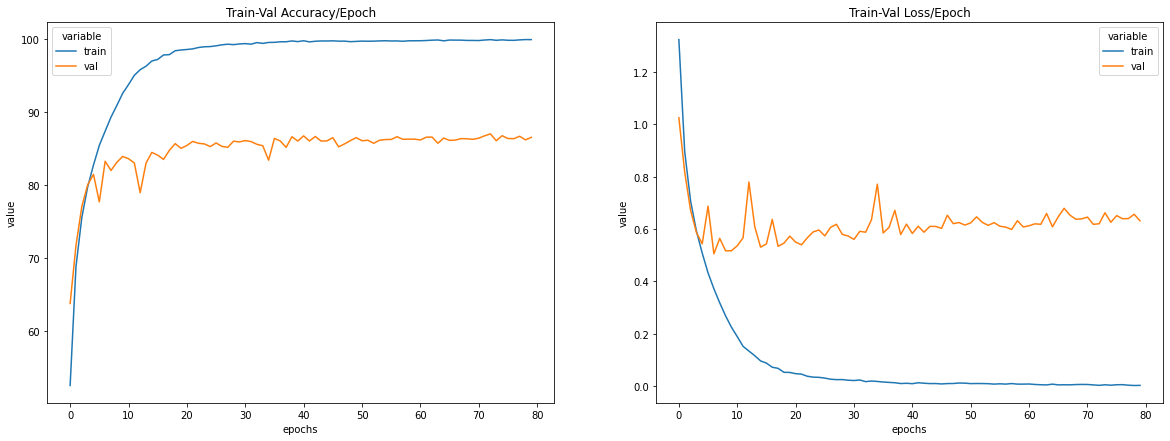

In [ ]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum()/len(correct_pred)
  acc = torch.round(acc*100)
  return acc

accuracy_stats = {'train':[], "val":[]}
loss_stats = {'train':[], "val":[]}
next(model.parameters()).is_cuda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
epochs = 80

print('Begin training...')
start_time = time.time()
print(start_time)
for e in tqdm(range(1, epochs+1)):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device),y_train_batch.to(device)
    optimizer.zero_grad()
    y_train_pred = model(X_train_batch)
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()

  model.eval()
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0

    for X_val_batch, y_val_batch in valid_loader:
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
      y_val_pred = model(X_val_batch)
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(valid_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(valid_loader))

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

print("--- %s seconds ---" % (time.time() - start_time))

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x="epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1000
           1       0.92      0.94      0.93      1000
           2       0.79      0.81      0.80      1000
           3       0.75      0.70      0.72      1000
           4       0.82      0.86      0.84      1000
           5       0.82      0.78      0.80      1000
           6       0.90      0.89      0.89      1000
           7       0.92      0.86      0.89      1000
           8       0.91      0.93      0.92      1000
           9       0.93      0.91      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



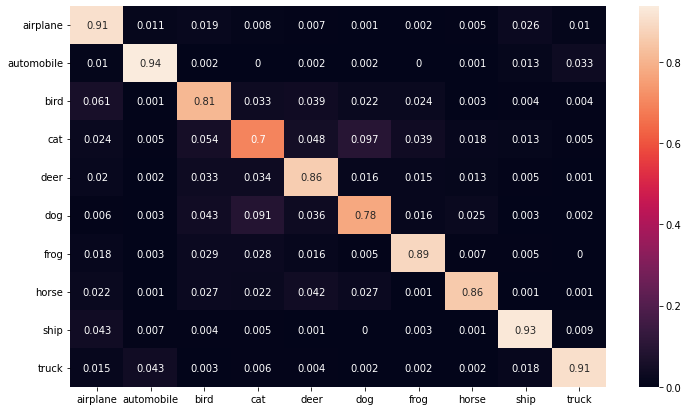

In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

print(classification_report(y_true, y_pred))

In [ ]:
# minigooglenet architecture
class miniGoogLeNet(nn.Module):
    def __init__(self, num_class, size, depth):
        super().__init__()
        self.num_class = num_class
        self.size = size
        self.depth = depth
        self.conv = convMod(in_channels=depth, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.inception1 = inceptionMod(in_channels=96, k1x1=32, k3x3=32)
        self.inception2 = inceptionMod(in_channels=64, k1x1=32, k3x3=48)
        self.downsample1 = downsampleMod(in_channels=80, k=80)
        self.inception3 = inceptionMod(in_channels=160, k1x1=112, k3x3=48)
        self.inception4 = inceptionMod(in_channels=160, k1x1=96, k3x3=64)
        self.inception5 = inceptionMod(in_channels=160, k1x1=80, k3x3=80)
        self.inception6 = inceptionMod(in_channels=160, k1x1=48, k3x3=96)
        self.downsample2 = downsampleMod(in_channels=144, k=96)
        self.inception7 = inceptionMod(in_channels=240, k1x1=176, k3x3=160)
        self.inception8 = inceptionMod(in_channels=336, k1x1=176, k3x3=160)
        self.fc = nn.Linear(in_features=336, out_features=num_class)

    def forward(self, x): # input shape is 3x28x28
        x = self.conv(x)  # 96x28x28
        x = self.inception1(x) # 64x28x28
        x = self.inception2(x) # 80x28x28
        x = self.downsample1(x) # 160x13x13
        x = self.inception3(x) # 160x13x13
        x = self.inception4(x) # 160x13x13
        x = self.inception5(x) # 160x13x13
        x = self.inception6(x) # 144x13x13
        x = self.downsample2(x) # 240x6x6
        x = self.inception7(x) # 336x6x6
        x = self.inception8(x) # 336x6x6
        x = F.avg_pool2d(x, kernel_size=7) # 366x1x1
        x = F.dropout(x, p=0.1) # 366x1x1
        x = x.view(x.size(0), -1) # 366
        x = self.fc(x) # 10
        return x

class inceptionMod(nn.Module):
    def __init__(self, in_channels, k1x1, k3x3):
        super(inceptionMod, self).__init__()
        self.conv1 = convMod(in_channels, k1x1, kernel_size=1)
        self.conv3 = convMod(in_channels, k3x3, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        outputs = [conv1, conv3]
        return torch.cat(outputs, 1)

class downsampleMod(nn.Module):
    def __init__(self, in_channels, k):
        super(downsampleMod, self).__init__()
        self.conv = convMod(in_channels, k, kernel_size=3, stride=2)

    def forward(self, x):
        conv3 = self.conv(x)
        maxpool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [conv3, maxpool]
        return torch.cat(outputs, 1)

class convMod(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(convMod, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

model = miniGoogLeNet(len(classes), 32, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# architecture summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
       BatchNorm2d-2           [-1, 96, 32, 32]             192
           convMod-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           3,072
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           convMod-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          27,648
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           convMod-9           [-1, 32, 32, 32]               0
     inceptionMod-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           2,048
      BatchNorm2d-12           [-1, 32, 32, 32]              64
          convMod-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 48,

In [ ]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum()/len(correct_pred)
  acc = torch.round(acc*100)
  return acc

accuracy_stats = {'train':[], "val":[]}
loss_stats = {'train':[], "val":[]}
next(model.parameters()).is_cuda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
epochs = 80

print('Begin training...')
start_time = time.time()
print(start_time)
for e in tqdm(range(1, epochs+1)):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device),y_train_batch.to(device)
    optimizer.zero_grad()
    y_train_pred = model(X_train_batch)
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()

  model.eval()
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0

    for X_val_batch, y_val_batch in valid_loader:
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
      y_val_pred = model(X_val_batch)
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(valid_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(valid_loader))

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

print("--- %s seconds ---" % (time.time() - start_time))

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x="epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Begin training...
1636247375.5522332


  1%|▏         | 1/80 [02:09<2:50:56, 129.83s/it]

Epoch 001: | Train Loss: 1.49465 | Val Loss: 1.31776 | Train Acc: 45.063 | Val Acc: 52.678


  2%|▎         | 2/80 [04:19<2:48:58, 129.98s/it]

Epoch 002: | Train Loss: 1.14065 | Val Loss: 1.12273 | Train Acc: 59.349 | Val Acc: 59.987


  4%|▍         | 3/80 [06:29<2:46:46, 129.95s/it]

Epoch 003: | Train Loss: 0.99942 | Val Loss: 0.89650 | Train Acc: 64.468 | Val Acc: 68.011


  5%|▌         | 4/80 [08:38<2:44:06, 129.56s/it]

Epoch 004: | Train Loss: 0.89355 | Val Loss: 0.86666 | Train Acc: 68.590 | Val Acc: 69.774


  6%|▋         | 5/80 [10:47<2:41:42, 129.36s/it]

Epoch 005: | Train Loss: 0.81469 | Val Loss: 0.80675 | Train Acc: 71.498 | Val Acc: 71.230


  8%|▊         | 6/80 [12:56<2:39:19, 129.18s/it]

Epoch 006: | Train Loss: 0.75681 | Val Loss: 0.72314 | Train Acc: 73.819 | Val Acc: 75.059


  9%|▉         | 7/80 [15:05<2:37:05, 129.12s/it]

Epoch 007: | Train Loss: 0.70077 | Val Loss: 0.72180 | Train Acc: 75.582 | Val Acc: 75.147


 10%|█         | 8/80 [17:14<2:34:53, 129.08s/it]

Epoch 008: | Train Loss: 0.66019 | Val Loss: 0.76462 | Train Acc: 77.429 | Val Acc: 73.491


 11%|█▏        | 9/80 [19:23<2:32:49, 129.15s/it]

Epoch 009: | Train Loss: 0.62154 | Val Loss: 0.65872 | Train Acc: 78.483 | Val Acc: 77.005


 12%|█▎        | 10/80 [21:32<2:30:36, 129.09s/it]

Epoch 010: | Train Loss: 0.58980 | Val Loss: 0.64637 | Train Acc: 79.670 | Val Acc: 77.682


 14%|█▍        | 11/80 [23:41<2:28:26, 129.08s/it]

Epoch 011: | Train Loss: 0.55992 | Val Loss: 0.60453 | Train Acc: 80.635 | Val Acc: 79.099


 15%|█▌        | 12/80 [25:51<2:26:19, 129.11s/it]

Epoch 012: | Train Loss: 0.53322 | Val Loss: 0.60713 | Train Acc: 81.696 | Val Acc: 78.819


 16%|█▋        | 13/80 [27:59<2:24:03, 129.01s/it]

Epoch 013: | Train Loss: 0.51346 | Val Loss: 0.60138 | Train Acc: 82.448 | Val Acc: 79.394


 18%|█▊        | 14/80 [30:08<2:21:48, 128.92s/it]

Epoch 014: | Train Loss: 0.49350 | Val Loss: 0.63617 | Train Acc: 83.082 | Val Acc: 78.398


 19%|█▉        | 15/80 [32:17<2:19:36, 128.88s/it]

Epoch 015: | Train Loss: 0.47040 | Val Loss: 0.58982 | Train Acc: 83.792 | Val Acc: 79.771


 20%|██        | 16/80 [34:26<2:17:28, 128.88s/it]

Epoch 016: | Train Loss: 0.44713 | Val Loss: 0.60737 | Train Acc: 84.769 | Val Acc: 79.440


 21%|██▏       | 17/80 [36:35<2:15:18, 128.87s/it]

Epoch 017: | Train Loss: 0.43494 | Val Loss: 0.57310 | Train Acc: 85.097 | Val Acc: 80.664


 22%|██▎       | 18/80 [38:43<2:13:07, 128.84s/it]

Epoch 018: | Train Loss: 0.41180 | Val Loss: 0.55766 | Train Acc: 86.037 | Val Acc: 81.261


 24%|██▍       | 19/80 [40:52<2:10:56, 128.80s/it]

Epoch 019: | Train Loss: 0.40601 | Val Loss: 0.57545 | Train Acc: 86.345 | Val Acc: 80.746


 25%|██▌       | 20/80 [43:01<2:08:50, 128.83s/it]

Epoch 020: | Train Loss: 0.38426 | Val Loss: 0.55091 | Train Acc: 87.019 | Val Acc: 81.677


 26%|██▋       | 21/80 [45:10<2:06:38, 128.79s/it]

Epoch 021: | Train Loss: 0.37254 | Val Loss: 0.58346 | Train Acc: 87.390 | Val Acc: 80.851


 28%|██▊       | 22/80 [47:18<2:04:28, 128.76s/it]

Epoch 022: | Train Loss: 0.35501 | Val Loss: 0.53493 | Train Acc: 87.875 | Val Acc: 82.493


 29%|██▉       | 23/80 [49:27<2:02:19, 128.76s/it]

Epoch 023: | Train Loss: 0.35142 | Val Loss: 0.56010 | Train Acc: 88.168 | Val Acc: 82.115


 30%|███       | 24/80 [51:36<2:00:11, 128.77s/it]

Epoch 024: | Train Loss: 0.33578 | Val Loss: 0.53922 | Train Acc: 88.748 | Val Acc: 81.805


 31%|███▏      | 25/80 [53:45<1:58:04, 128.81s/it]

Epoch 025: | Train Loss: 0.31778 | Val Loss: 0.54543 | Train Acc: 89.364 | Val Acc: 82.498


 32%|███▎      | 26/80 [55:54<1:55:53, 128.77s/it]

Epoch 026: | Train Loss: 0.30613 | Val Loss: 0.57485 | Train Acc: 89.752 | Val Acc: 81.715


In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

print(classification_report(y_true, y_pred))